In [ ]:
import pandas as pd
import numpy as np
from utils import preprocess, models
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split

ImportError: attempted relative import with no known parent package

In [ ]:
df = pd.read_csv("../data/1082-Device-Data-Fix.csv")
df = preprocess.get_clean_df(df)
df = preprocess.create_standarized_gradients(df)
df = preprocess.create_steps_from_irrigation(df)

In [ ]:
THRESH_DOWN = -0.1
THRESH_UP = 0.1

plain_model = models.get_plain_predictor()

plain_dates = preprocess.get_plains_dates(df, THRESH_DOWN, THRESH_UP)
df["plain"] = False
df.loc[df["date"].isin(plain_dates), "plain"] = True
df_decay = preprocess.get_dataset_from_df(df, THRESH_UP)

X = preprocess.get_inputs_plain_predictor(df_decay)
df_decay["plain"] = plain_model.predict(X)
df_decay["plain"] = df_decay["plain"].astype(bool)

X.head()

/home/p3rzival/miniconda3/envs/beca/lib/python3.12/pickle.py:1760: UserWarning: [22:41:20] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


soil_moisture_40  steps_from_peak  season_autumn  season_spring  \
0             0.277                0          False          False   
1             0.277                1          False          False   
2             0.277                2          False          False   
3             0.277                3          False          False   
4             0.277                4          False          False   

   season_summer  season_winter        hour_s  hour_c  
0          False           True  0.000000e+00     1.0  
1          False           True -2.449294e-16     1.0  
2          False           True -2.449294e-16     1.0  
3          False           True -4.898587e-16     1.0  
4          False           True -4.898587e-16     1.0

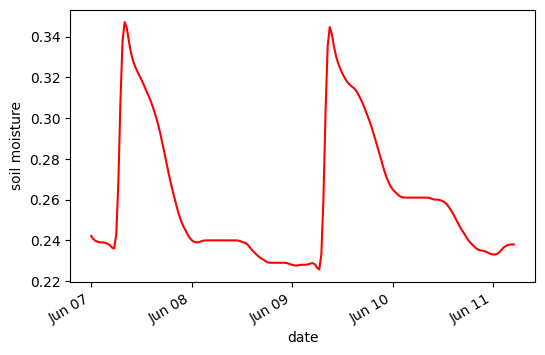

In [ ]:
start_date = pd.to_datetime("2024-06-07 00:00:00")
end_date   = pd.to_datetime("2024-06-11 05:00:00")
df_constricted = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
#We use the gradients to detect slopes and plains, but we first normalize to be able to get good scales for thresholding

restricted_mask = ~df_decay["plain"] & ~df_decay["up"]
restricted_dates = df_decay.loc[restricted_mask, "date"]

restricted_df = df_constricted.copy()
restricted_df["soil_moisture_40"] = np.nan
restricted_df["soil_moisture_40"] = df_constricted.loc[df_constricted["date"].isin(restricted_dates), "soil_moisture_40"]

plt.figure(figsize=(6, 4))

sns.lineplot(df_constricted, x="date", y="soil_moisture_40", color="red")
# plt.plot(restricted_df["date"], np.ma.masked_invalid(restricted_df["soil_moisture_40"].astype(float)))
# sns.lineplot(plain_df, x="date", y="soil_moisture_40", label="plain", color="blue")
# plt.ylim(0, 0.40)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate()  # rotate labels for clarity
plt.ylabel("soil moisture")
plt.savefig("cycle.eps", format="eps")
plt.show()

In [ ]:
df_decay_grouped = preprocess.separate_slopes_by_groups(df_decay)
df_decay_grouped = preprocess.compute_group_slopes(df_decay_grouped)
X, y = preprocess.compute_slopes_dataset(df_decay_grouped)
X.head()

/home/p3rzival/Saf/utils/preprocess.py:279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0007343901999730224' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_decay_grouped.loc[df_decay_grouped["group"] == i, "slope"] = m
/home/p3rzival/Saf/utils/preprocess.py:292: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_three_per_group = df_slopes.groupby('group').apply(lambda x: x.iloc[:3]).reset_index(drop=True).copy()


moisture_1  moisture_2  moisture_3  season_autumn  season_spring  \
0    0.342707    0.335025    0.329756          False           True   
1    0.343507    0.336263    0.331590          False           True   
2    0.353083    0.343245    0.336434          False           True   
3    0.348276    0.339413    0.333123          False           True   
4    0.306704    0.306296    0.306000          False           True   

   season_summer  season_winter        hour_s  hour_c  
0          False          False -4.898587e-16     1.0  
1          False          False -3.429011e-15     1.0  
2          False          False -1.077937e-14     1.0  
3          False          False -4.898587e-15     1.0  
4          False          False -3.918870e-15     1.0

In [ ]:
# import optuna
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import roc_auc_score, accuracy_score
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import xgboost as xgb


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# def objective(trial):

#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'max_depth': trial.suggest_int('max_depth', 2, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#         'random_state': 42
#     }

#     model = xgb.XGBRegressor(**params)

#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#     return -scores.mean()


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)
# print("Best CV MSE:", study.best_value)


# test_model = xgb.XGBRegressor(**study.best_params)
# test_model.fit(X_train, y_train)

# y_pred = test_model.predict(X_test)

# test_mae = mean_absolute_error(y_test, y_pred)

# print(f"Test MAE: {test_mae:.4f}")

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

In [ ]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

def line_regression(points):

    points = np.array(points)

    x = np.array([i for i in range(len(points))])
    y = points

    x0, y0 = x[0], y[0]

    X = (x - x0).reshape(-1, 1)
    Y = y - y0

    ransac = RANSACRegressor(
        estimator=LinearRegression(fit_intercept=False),
        min_samples=3,
        residual_threshold=1.5,  # tune this
        random_state=0
    )


    ransac.fit(X, Y)

    m = ransac.estimator_.coef_[0]

    return m

In [ ]:
import xgboost as xgb

def get_plain_input(moisture, df, idx, steps):

    plain_input = [[moisture],
                   [steps],
                   df.loc[idx, ["season_autumn", "season_spring", "season_summer", "season_winter"]].values,
                   ]

    plain_input = np.concat(plain_input)


    plain_input = pd.DataFrame(plain_input.reshape(1, -1), columns=["soil_moisture_40", "steps_from_peak", "season_autumn", "season_spring", "season_summer", "season_winter"])
    plain_input = plain_input.astype(df.dtypes[plain_input.columns])
    plain_input["hour_s"] = np.sin(2 * np.pi * df.loc[idx, "date"].hour)
    plain_input["hour_c"] = np.cos(2 * np.pi * df.loc[idx, "date"].hour)
    return plain_input

def update_prediction(df_predicted, m, b, starting_idx):

    MAX_STEPS = 100
    
    dates = [df_predicted.loc[starting_idx, "date"]]
    values = [df_predicted.loc[starting_idx, "soil_moisture_40"]]

    plain_input = get_plain_input(df_predicted.loc[starting_idx, "soil_moisture_40"], df_predicted, starting_idx, 0)
    plain_steps = 0
    stop_steps = None
    
    #We predict only up to the next irrigation for a better viewing for the animation
    
    for step in range(MAX_STEPS):

        if df_predicted.loc[starting_idx + step, "irrigation_volume_0"] > 0:
            stop_steps = step
            break

        if plain_model.predict(plain_input):
            plain_steps += 1
            prev_val = values[-1]
            values.append(prev_val)
        
        else:
            values.append(m*(step-plain_steps) + b)

        plain_input = get_plain_input(values[-1], df_predicted, starting_idx, step)


    if stop_steps is None:
        stop_steps = MAX_STEPS

    df = pd.DataFrame({
    "date" : df_predicted.loc[starting_idx:starting_idx + stop_steps, "date"],
    "soil_moisture_40": values,
    "real_values" : df_predicted.loc[starting_idx:starting_idx + stop_steps, "soil_moisture_40"]
    })

    return df

In [ ]:
def create_frame(df_predicted, df_constricted,frame,prev_predicted):

    plt.figure(figsize=(20, 10))
    sns.lineplot(df_constricted, x="date", y="soil_moisture_40", label="depth40", color="red")
    sns.lineplot(df_predicted, x="date", y="soil_moisture_40", label="predicted", color="blue")
    for idx, df in enumerate(prev_predicted):
        sns.lineplot(df, x="date", y="soil_moisture_40", label=f"predicted{idx}", linewidth=3)
    # sns.lineplot(plain_df, x="date", y="soil_moisture_40", label="plain", color="blue")
    plt.legend(title="Depth Variables")
    # plt.ylim(0, 0.40)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.gcf().autofmt_xdate()  # rotate labels for clarity
    # plt.savefig(f"frames/frame{frame}.png")
    plt.show()

In [ ]:
def create_frame_pointed(df_predicted,new_prediction,frame,idx):

    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=df_predicted.loc[:idx, "date"], y=df_predicted.loc[:idx, "soil_moisture_40"], color="Blue", label="Seen points")
    plt.xlim(start_date, end_date)
    plt.ylim(0.20, 0.35)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.gcf().autofmt_xdate()  # rotate labels for clarity
    sns.lineplot(new_prediction, x="date", y="soil_moisture_40", color="Red", label="Predicted")
    sns.lineplot(new_prediction, x="date", y="real_values", color="Green", label="Real future behaviour")
    plt.legend(loc="upper right")
    plt.show()
    # plt.savefig(f"frames_line/frame{frame:04d}.png")
    # plt.close()

227


Processing rows::   0%|          | 0/227 [00:00<?, ?row/s]

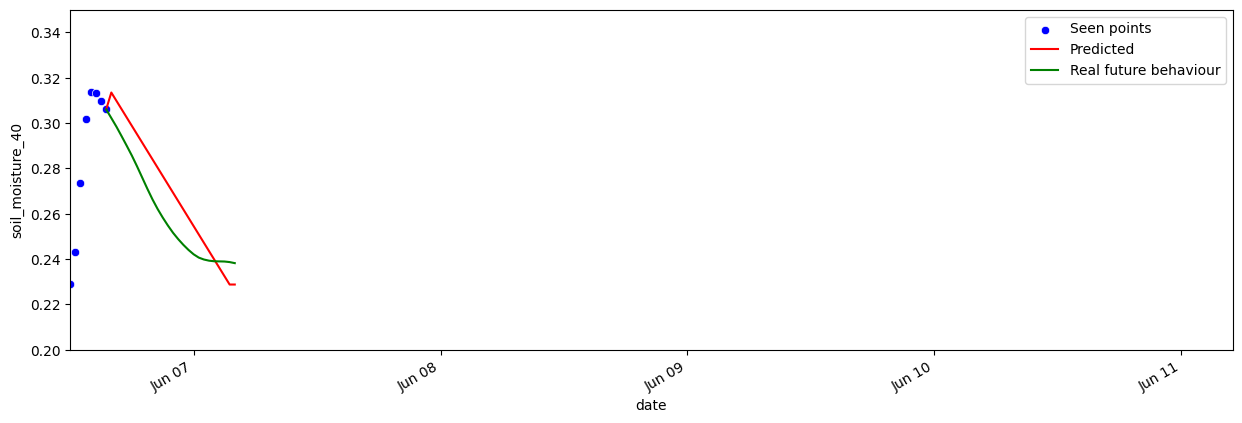

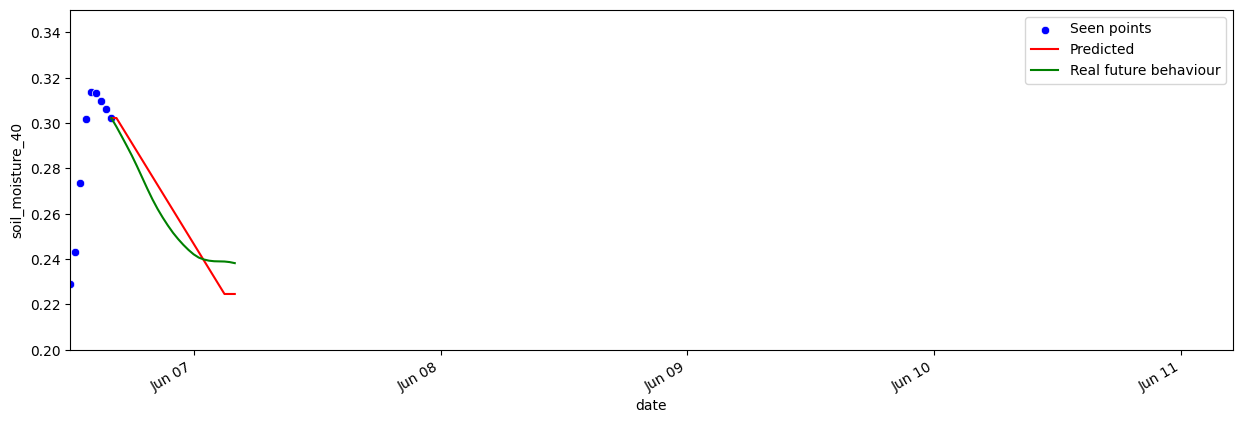

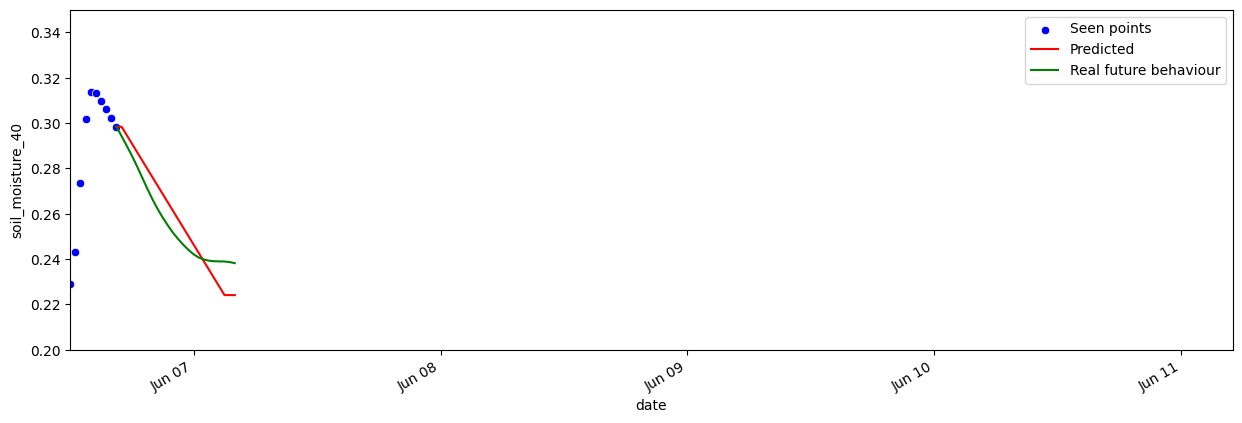

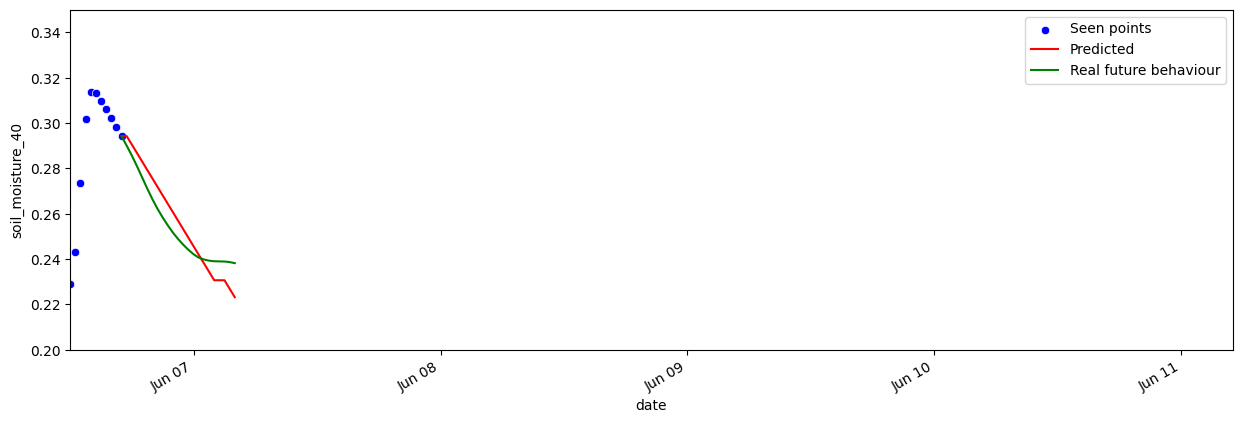

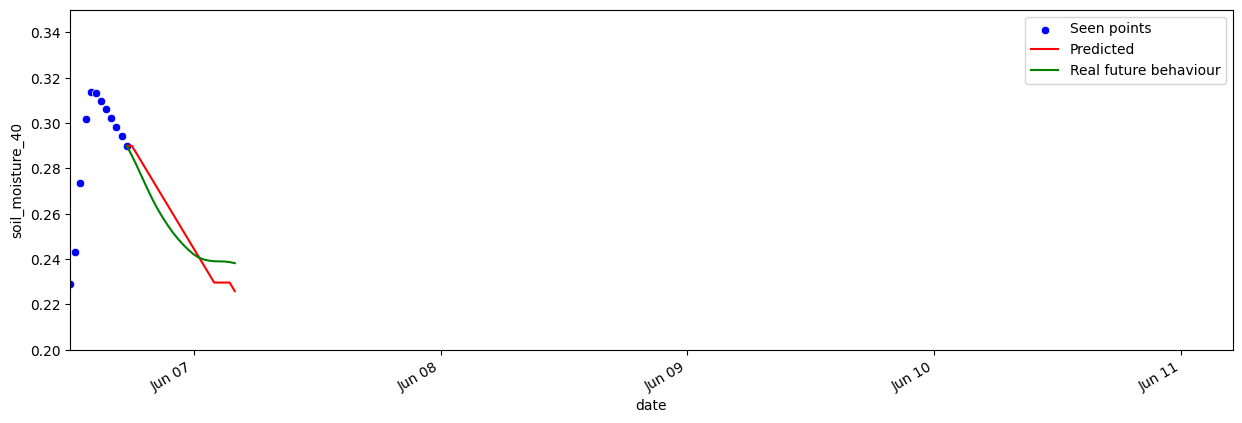

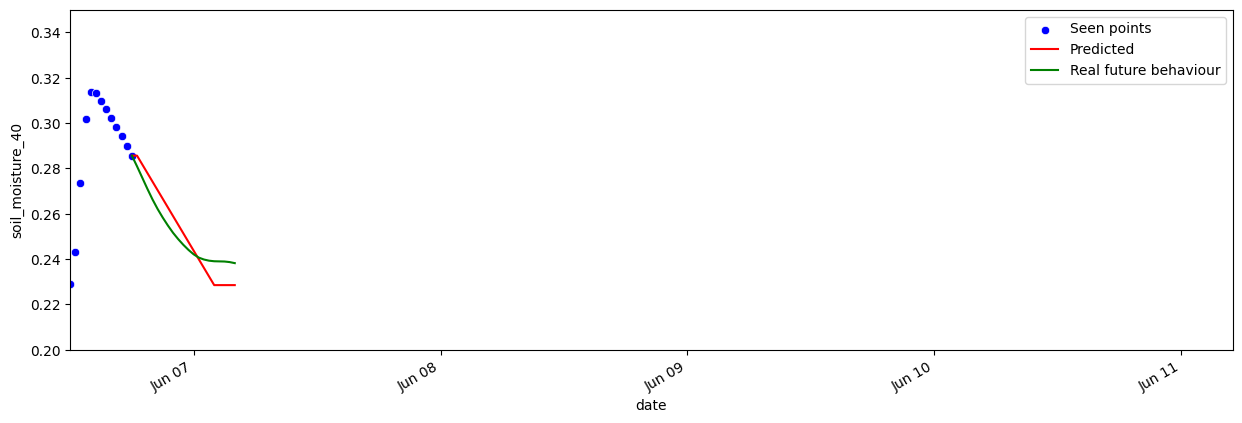

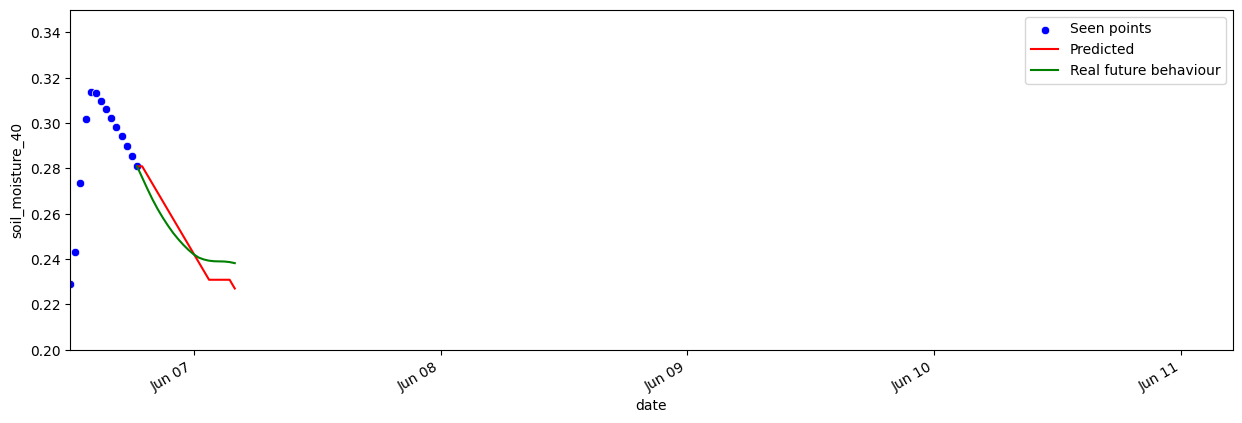

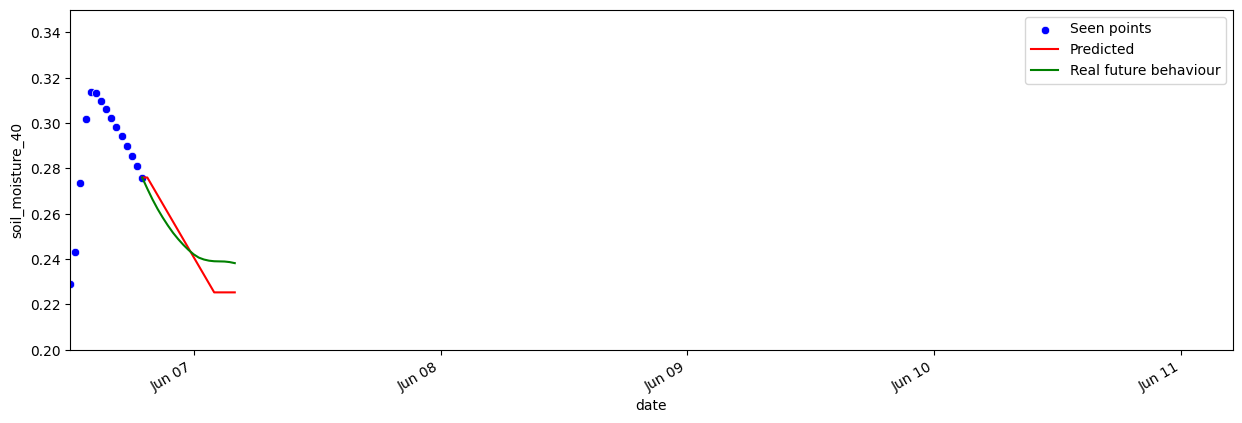

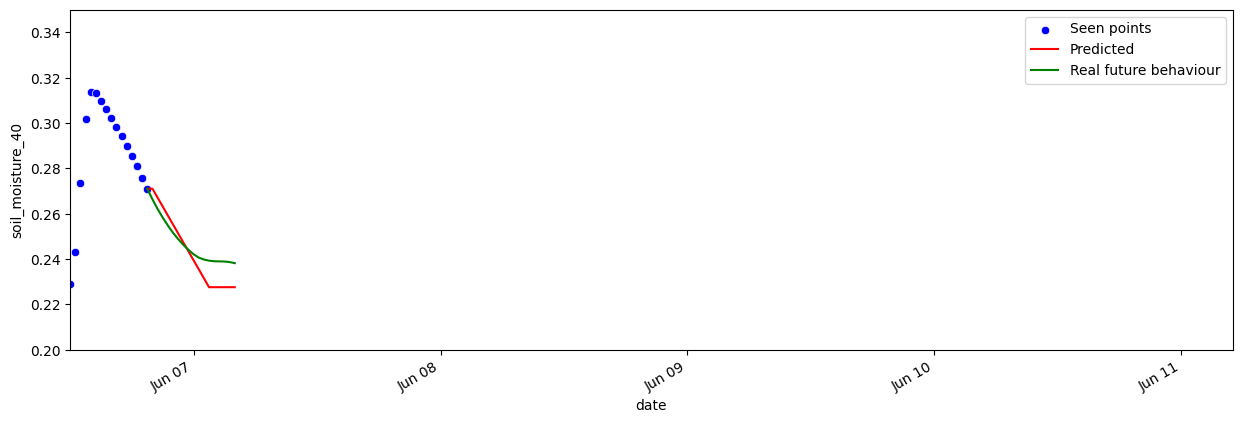

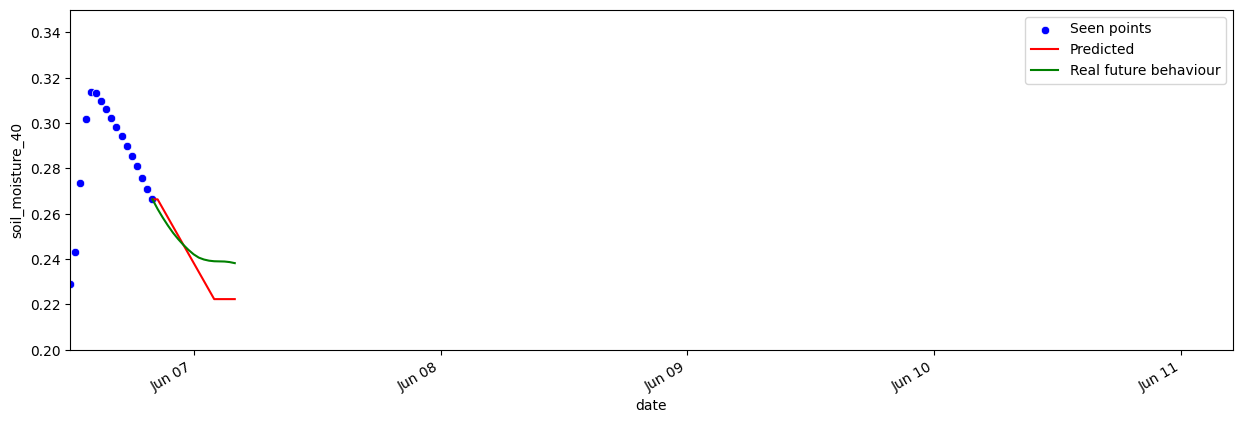

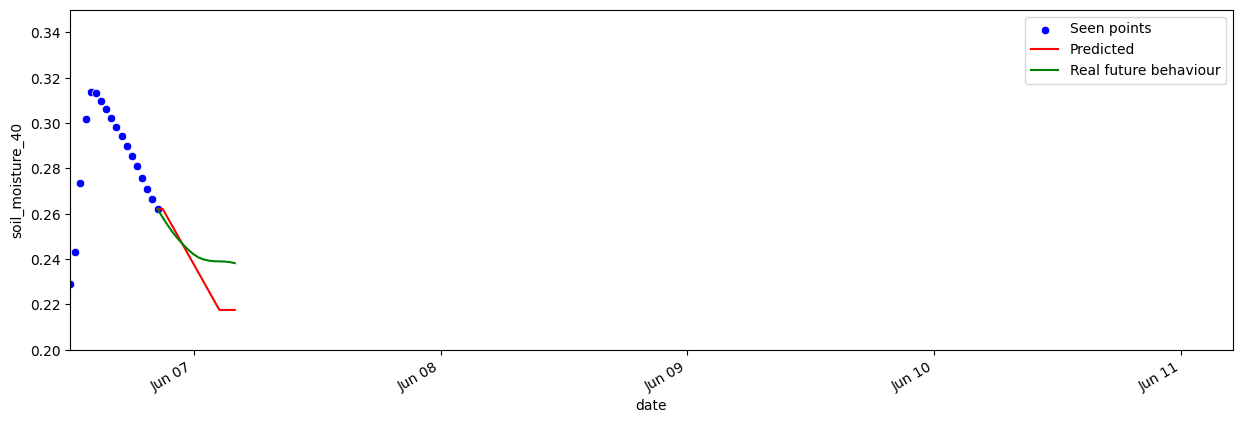

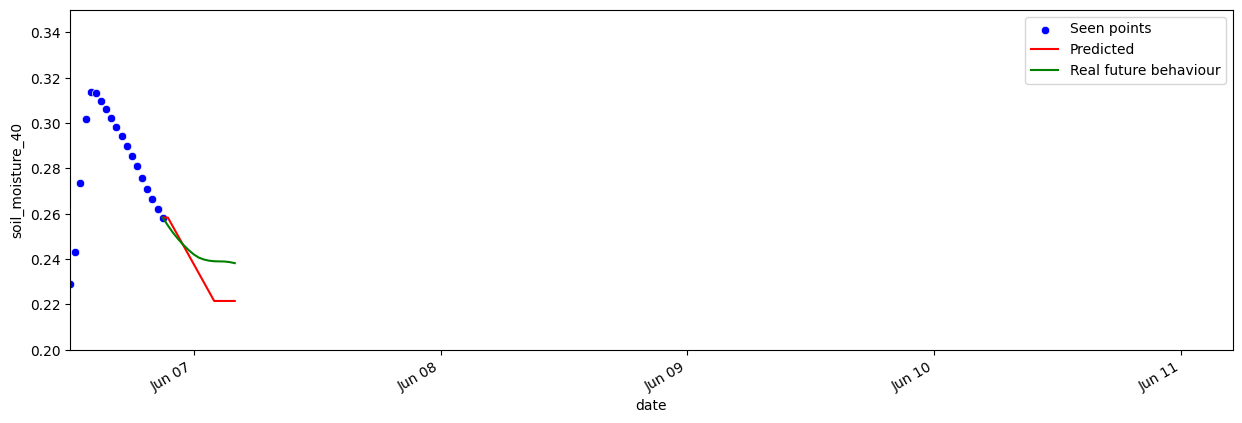

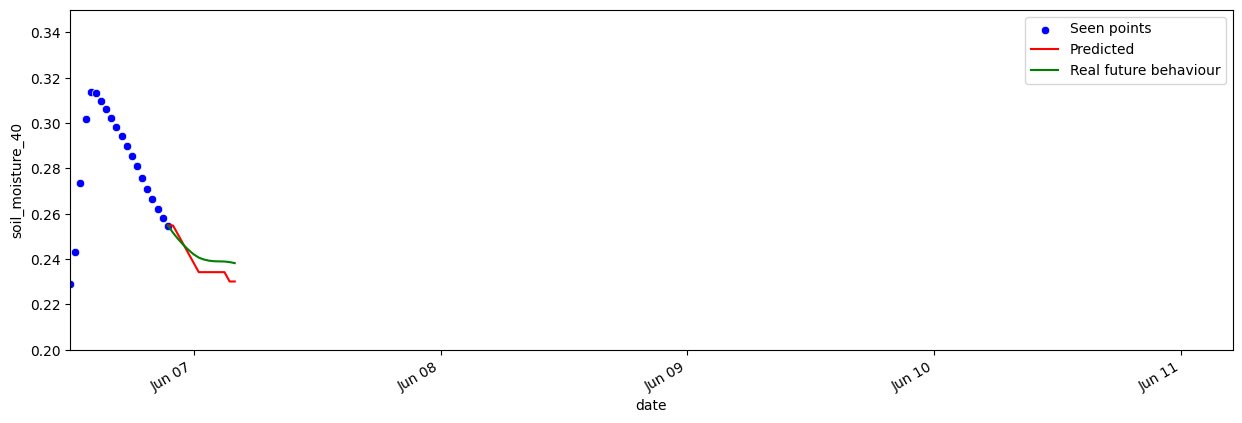

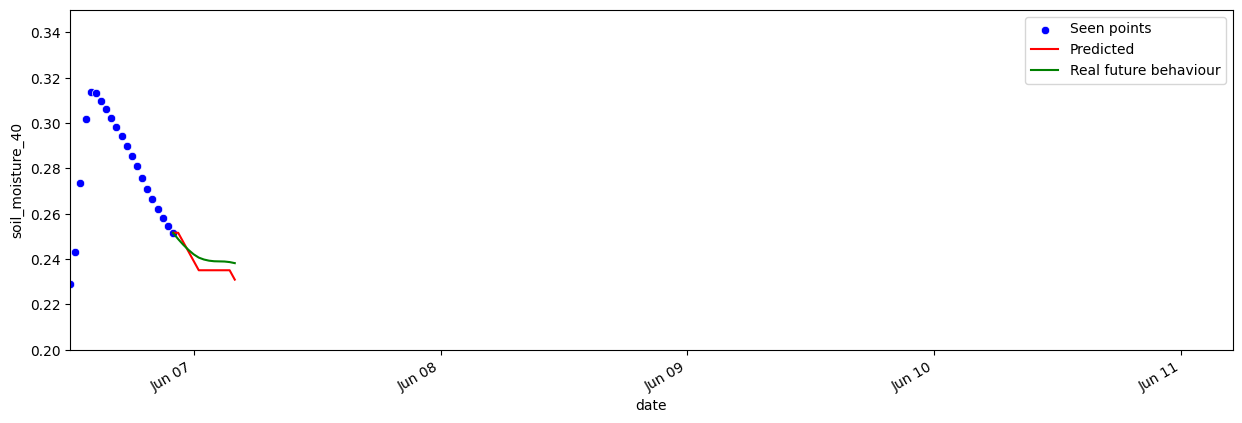

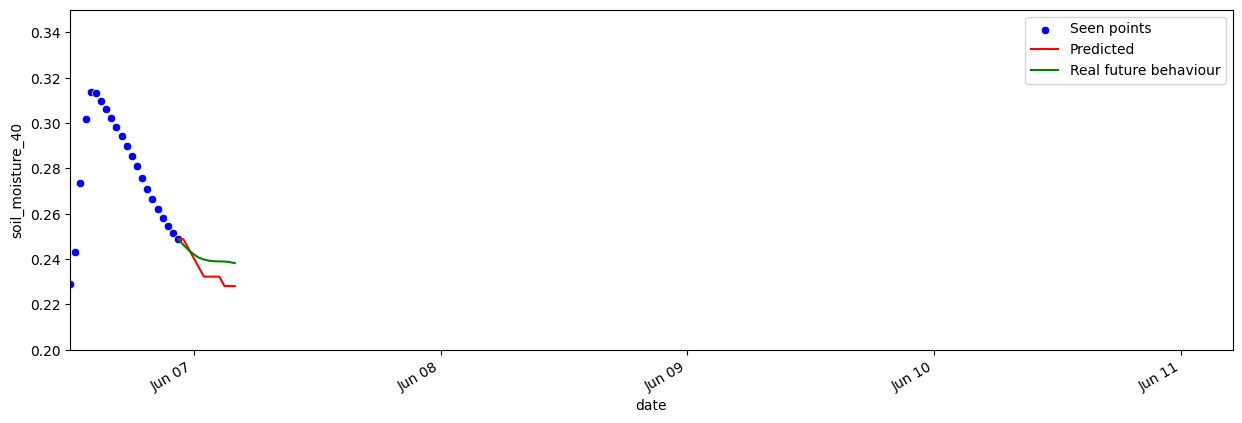

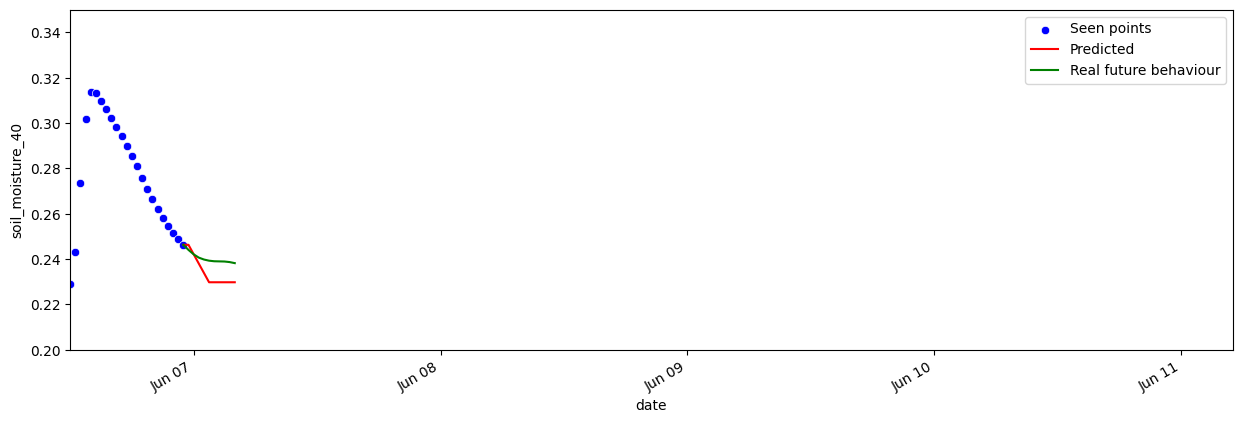

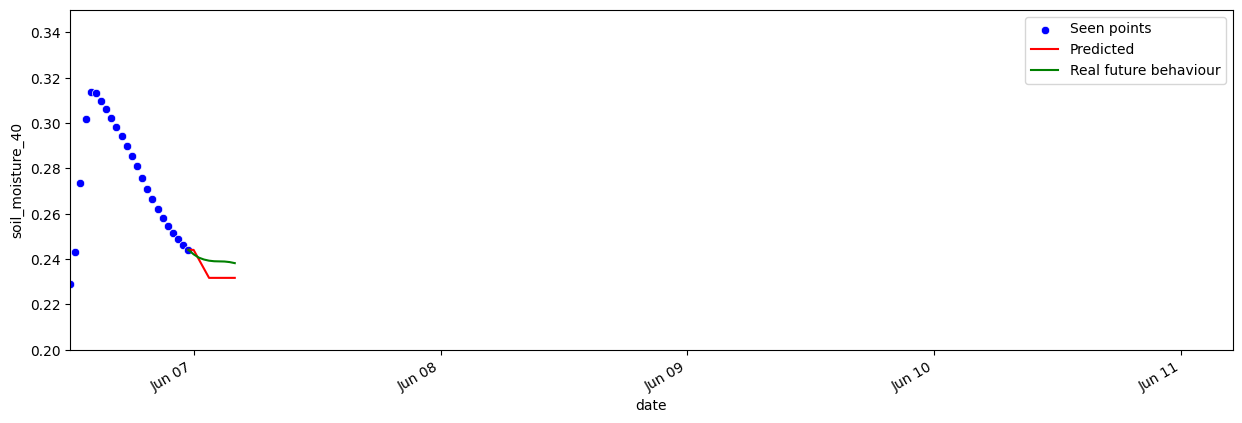

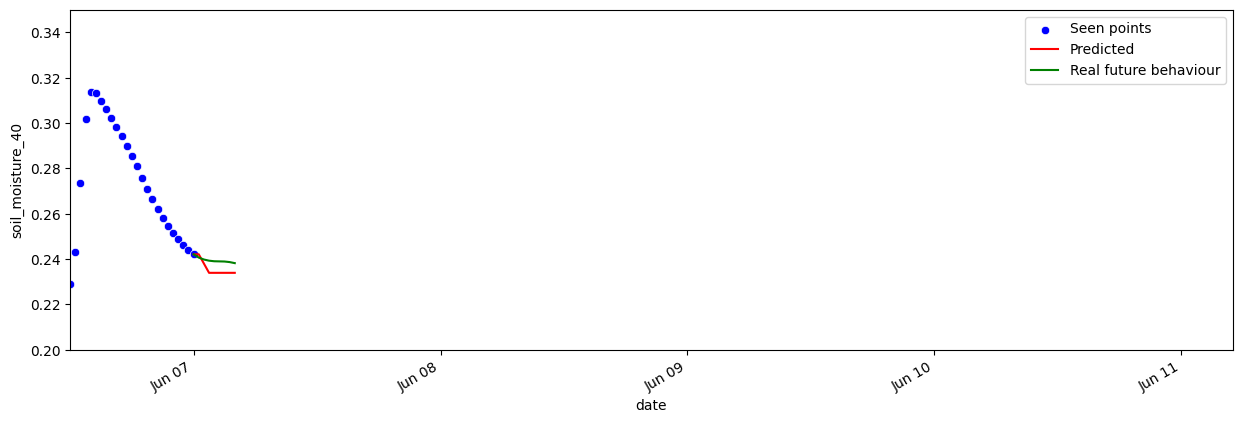

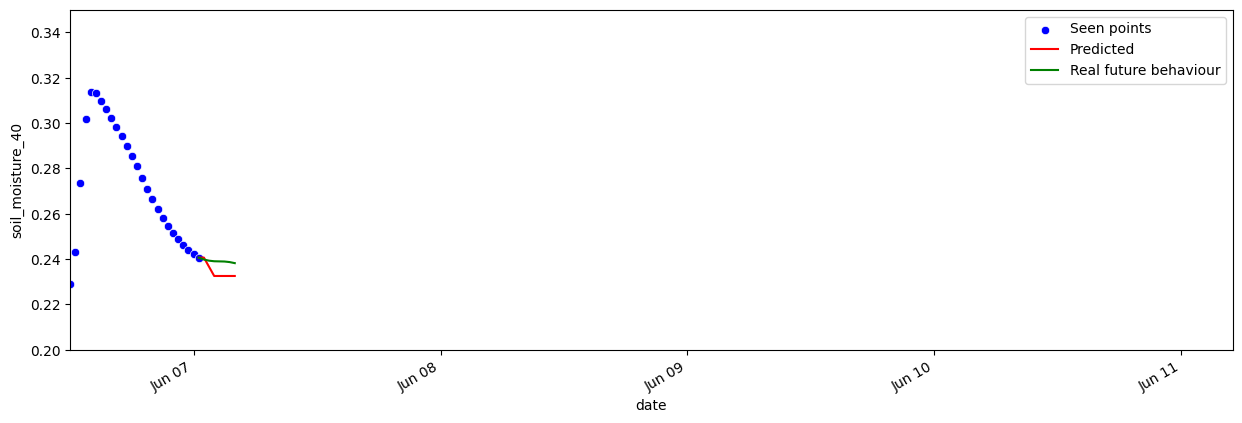

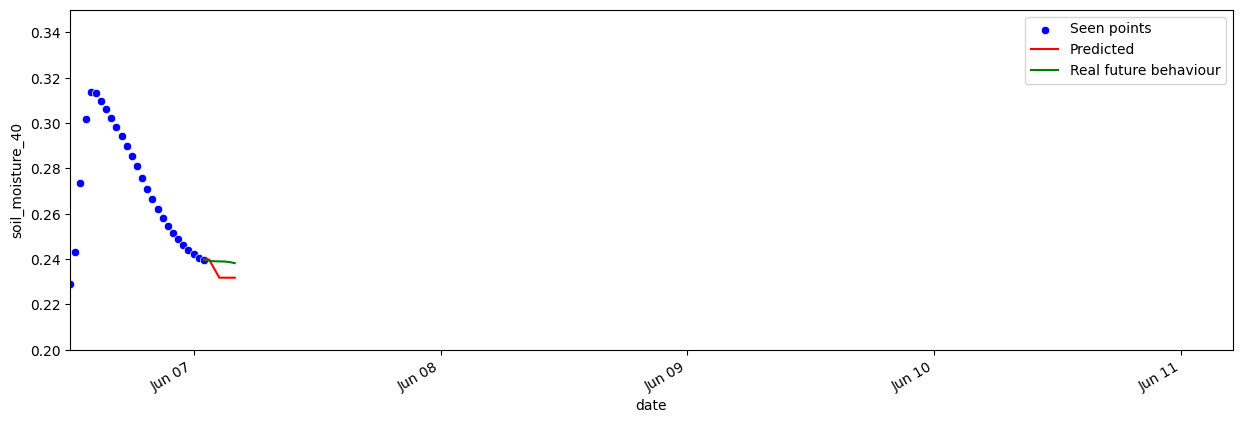

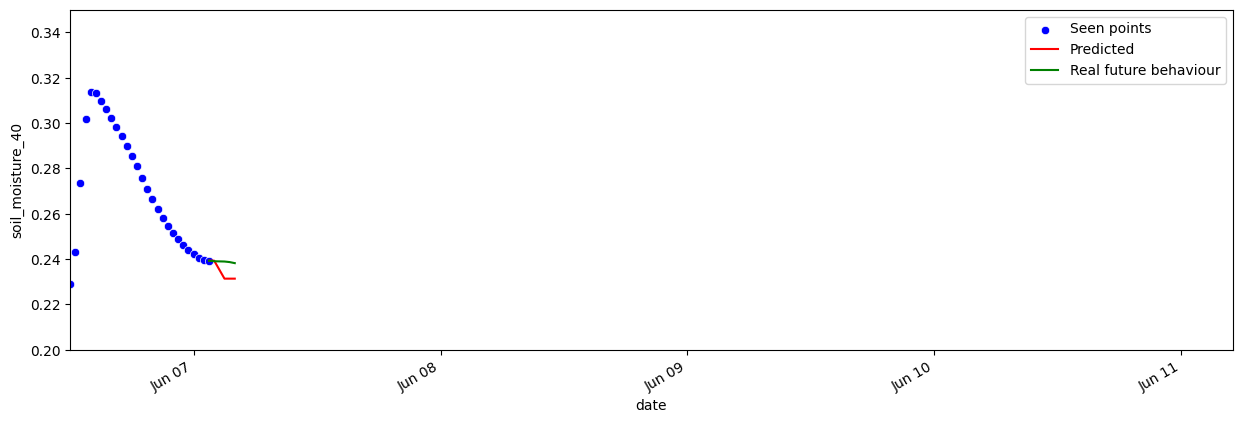

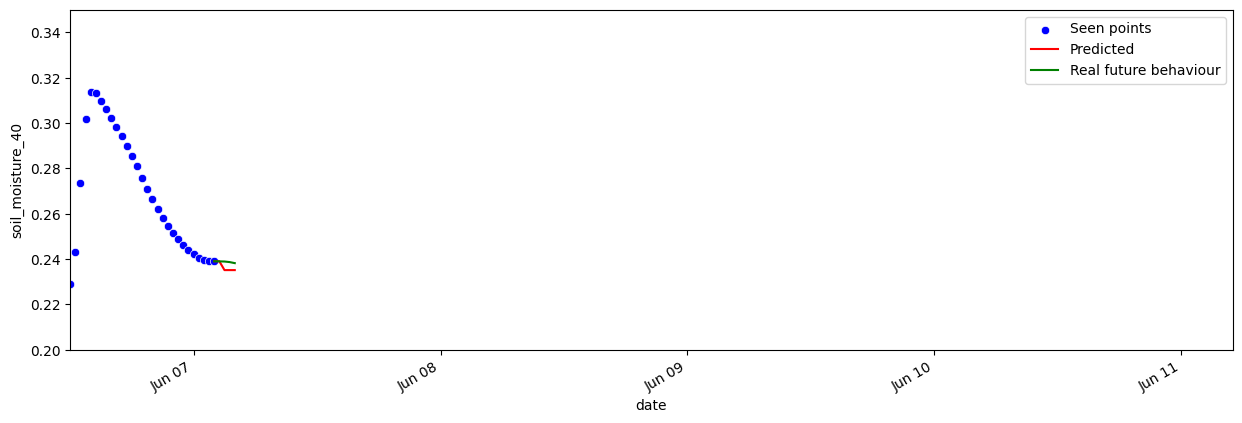

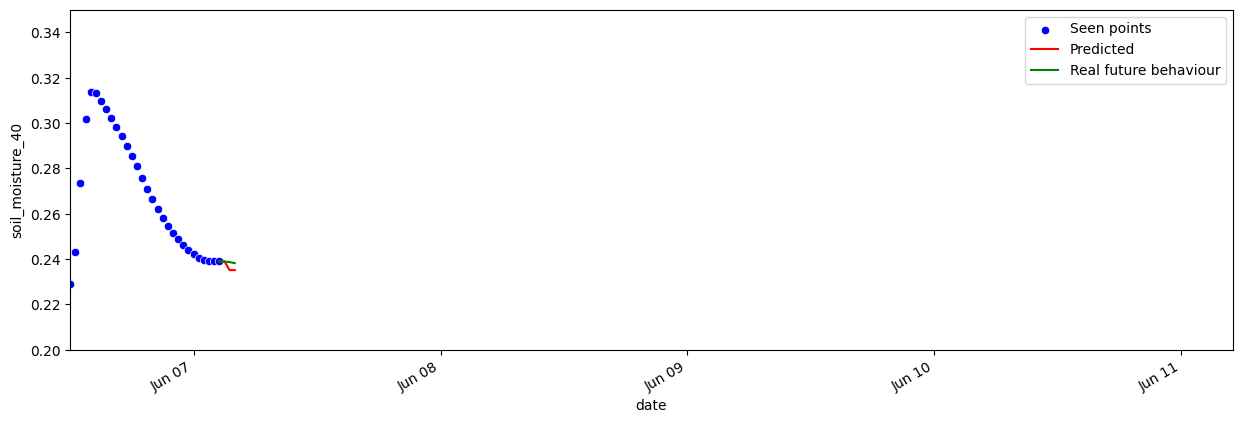

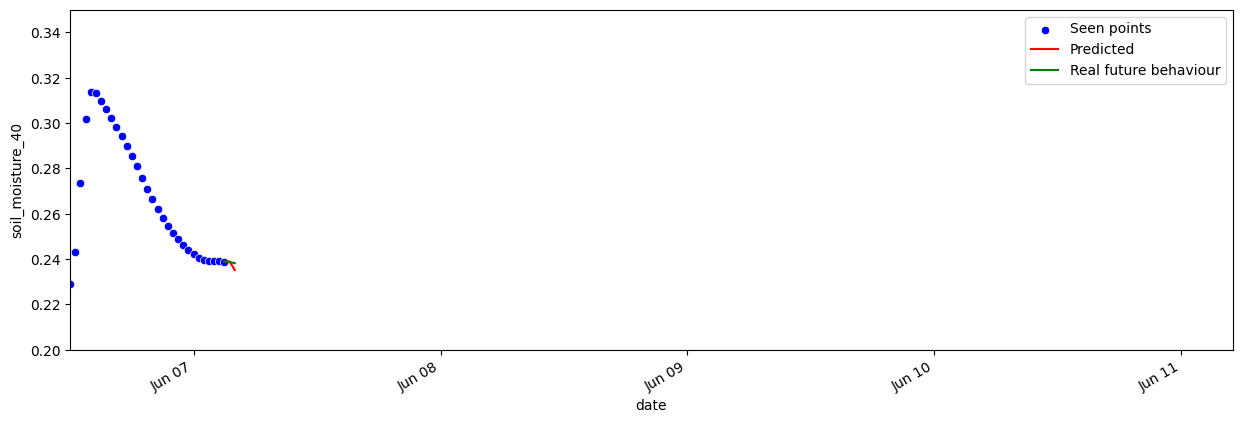

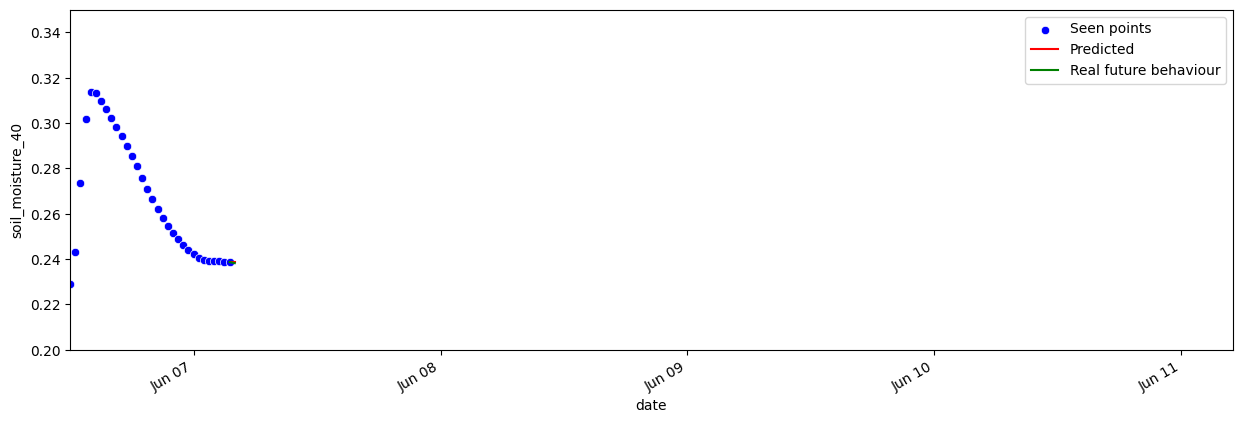

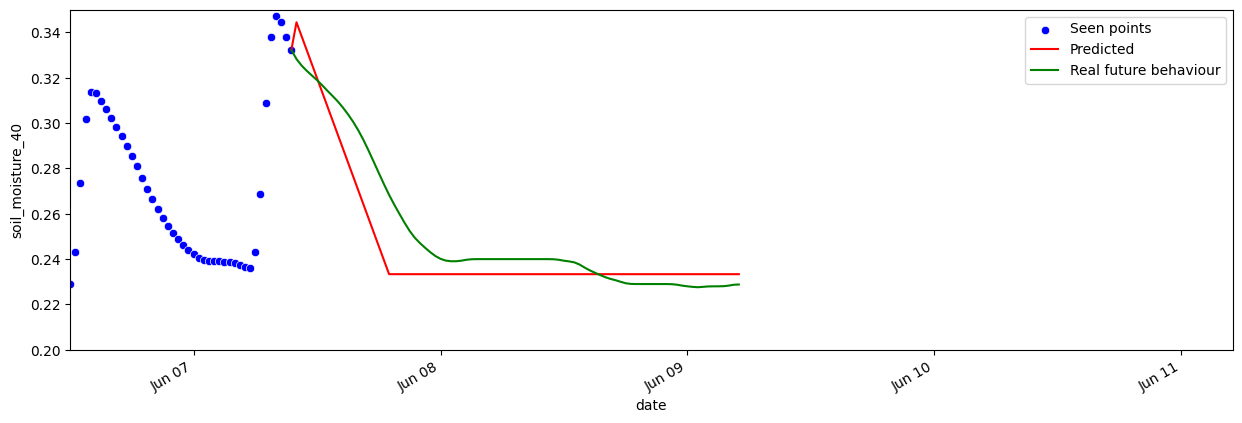

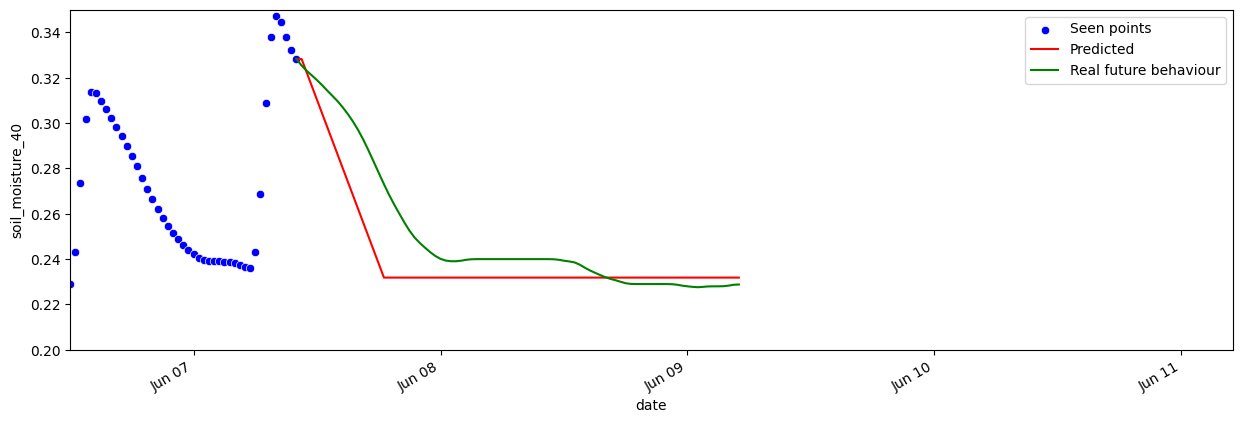

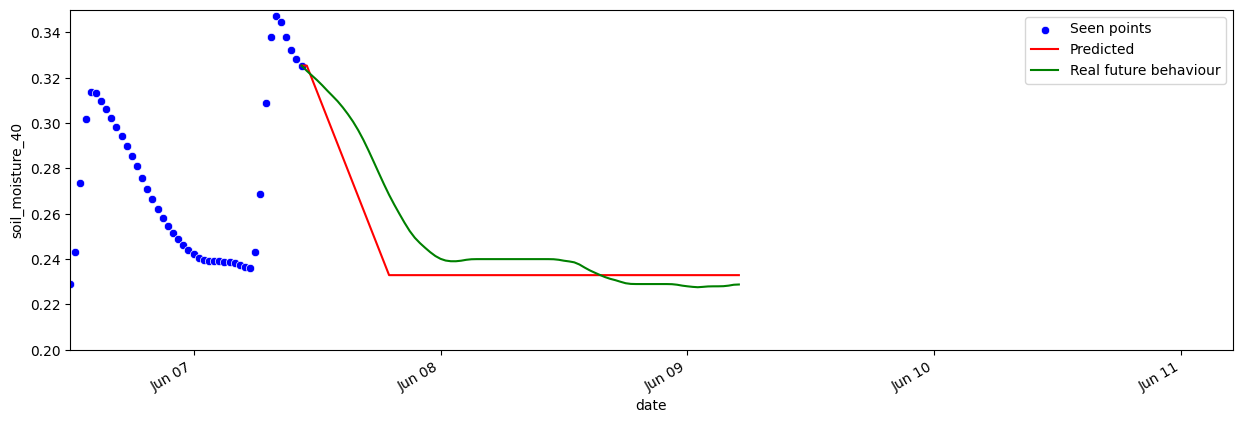

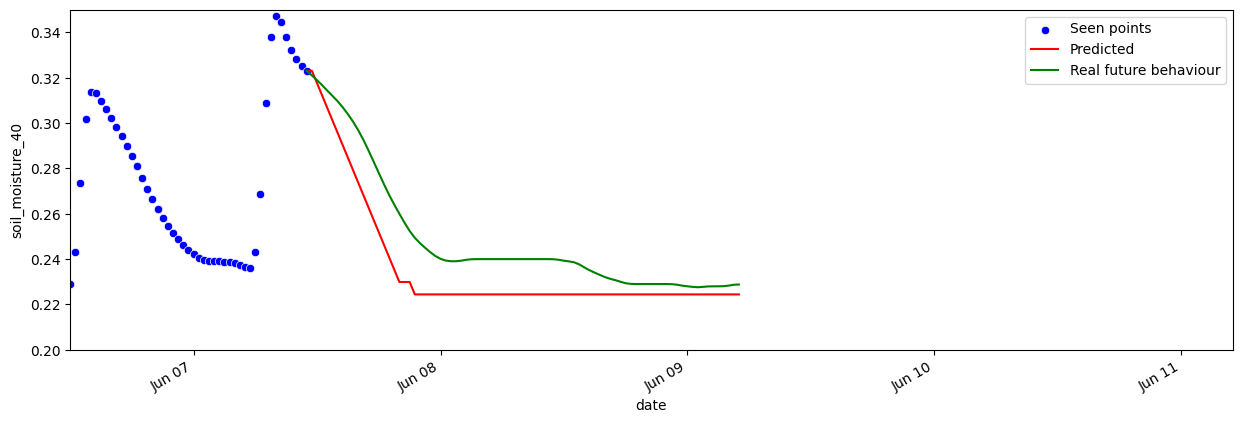

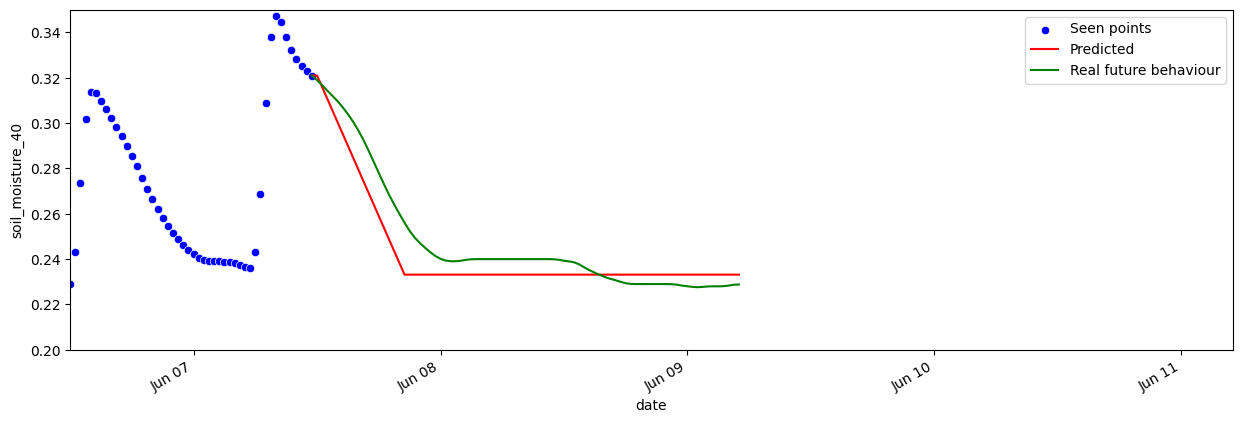

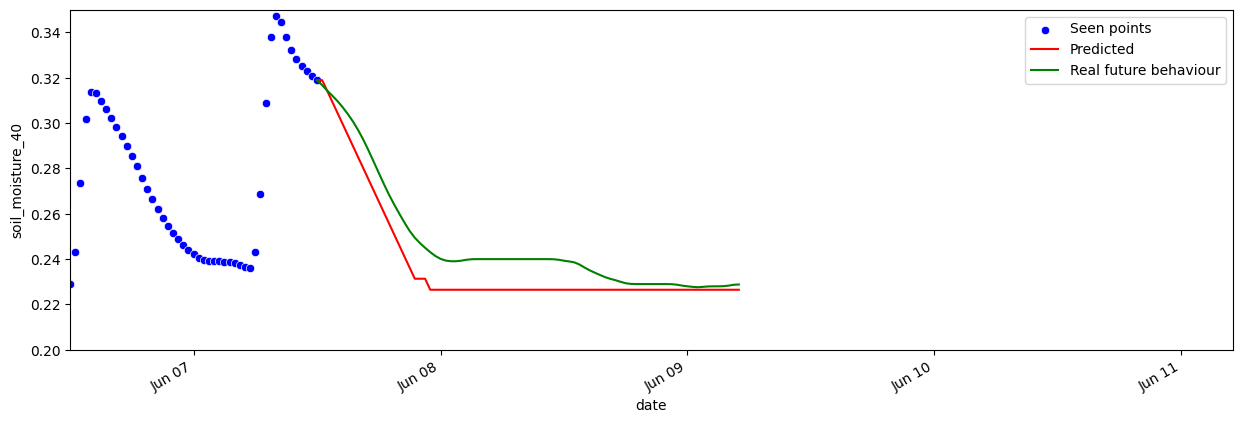

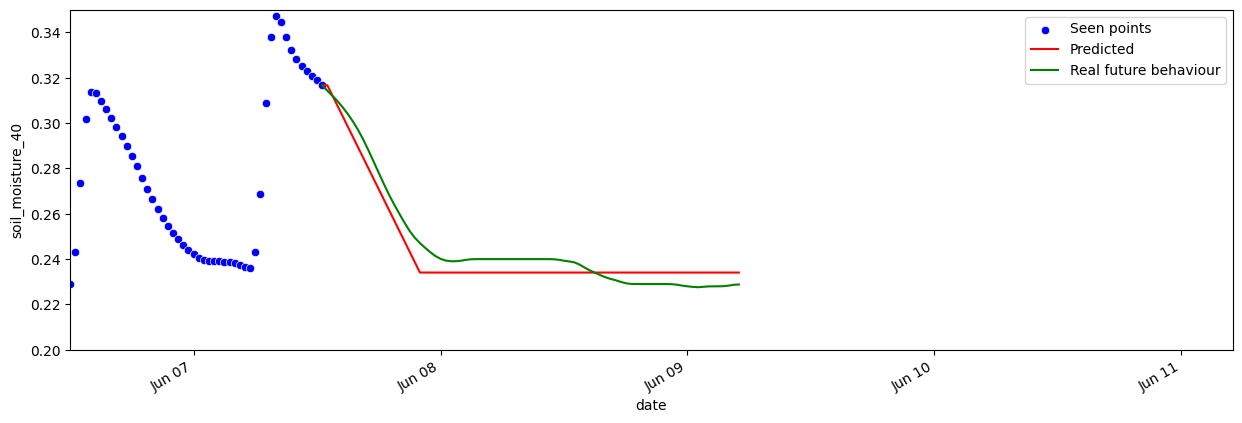

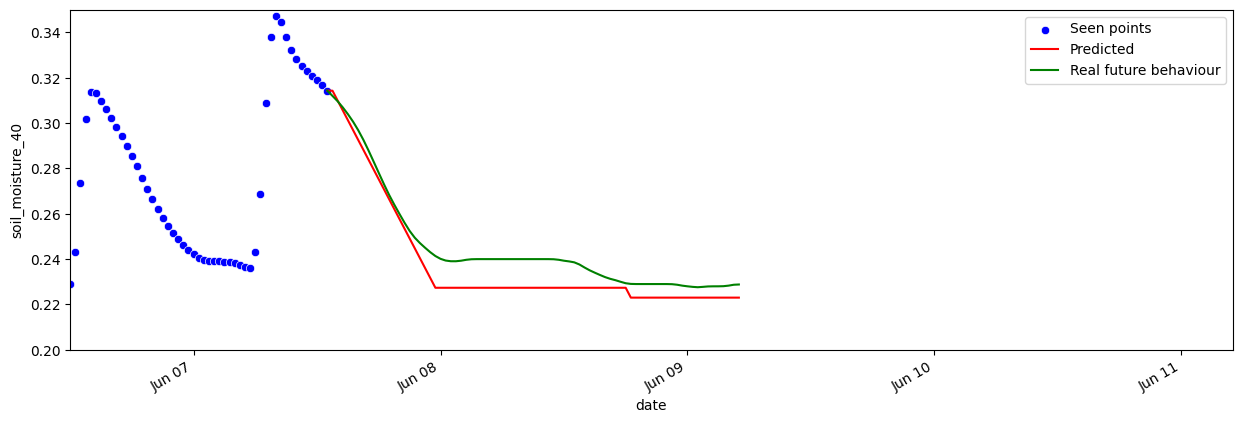

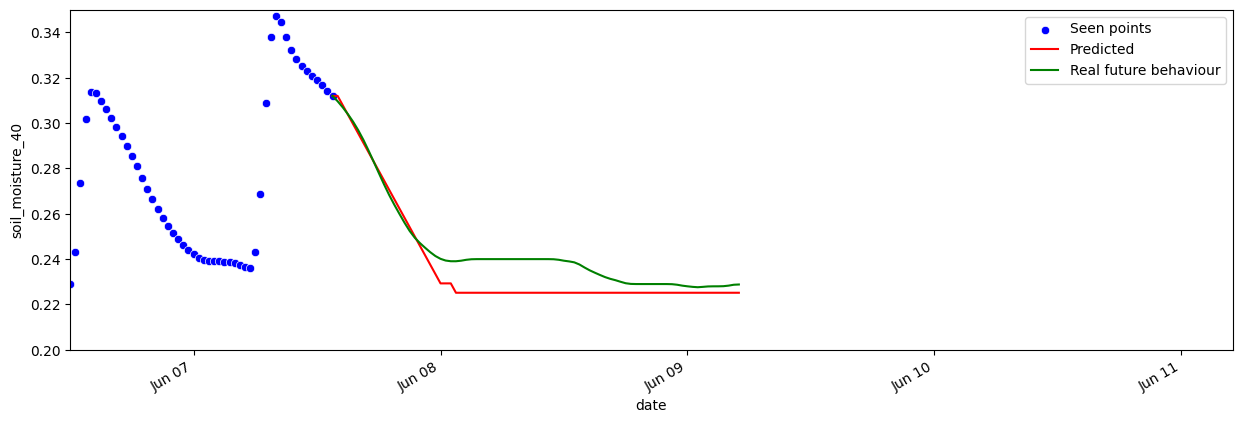

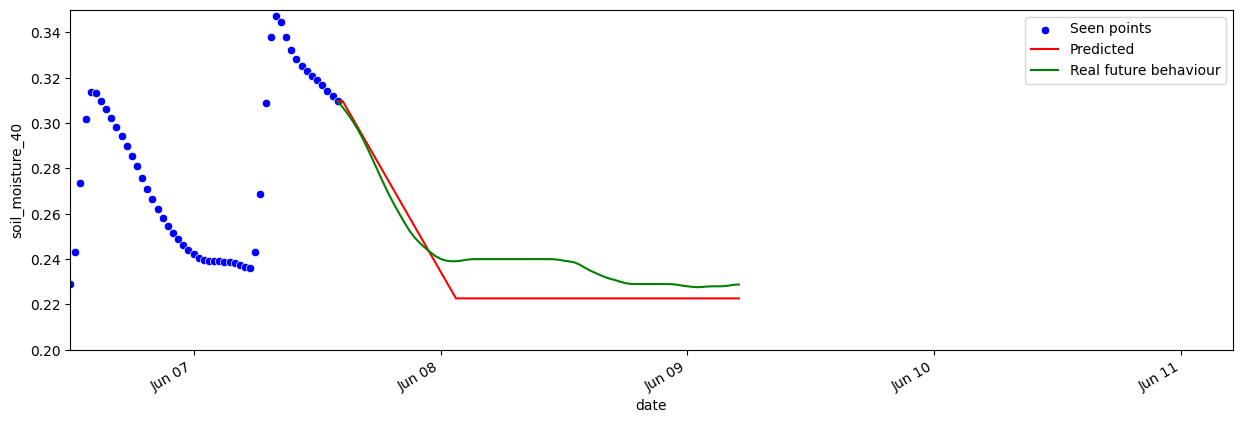

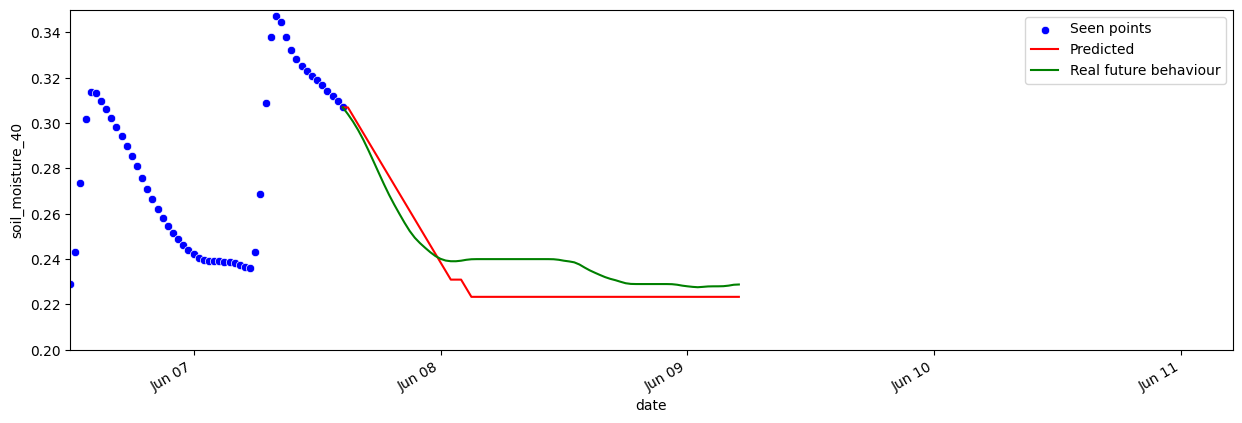

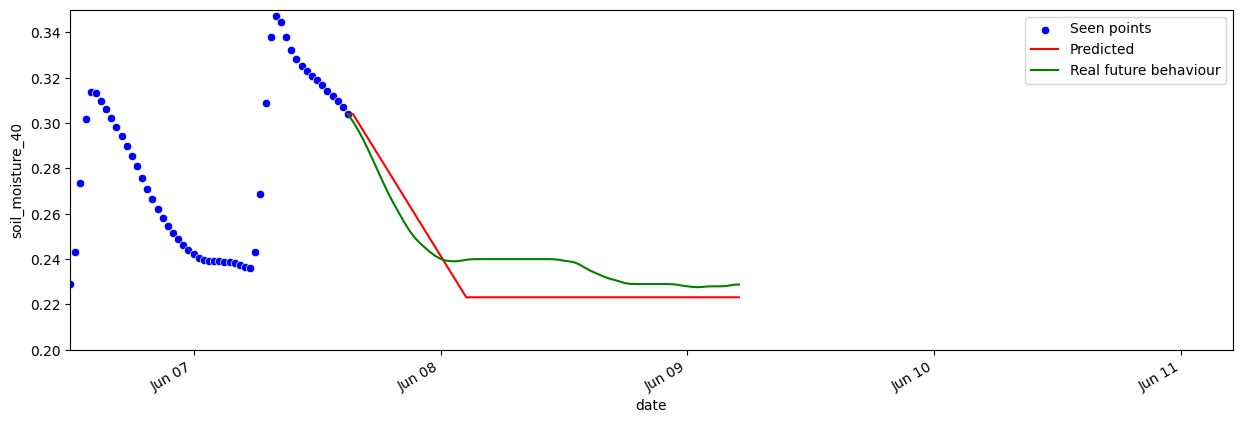

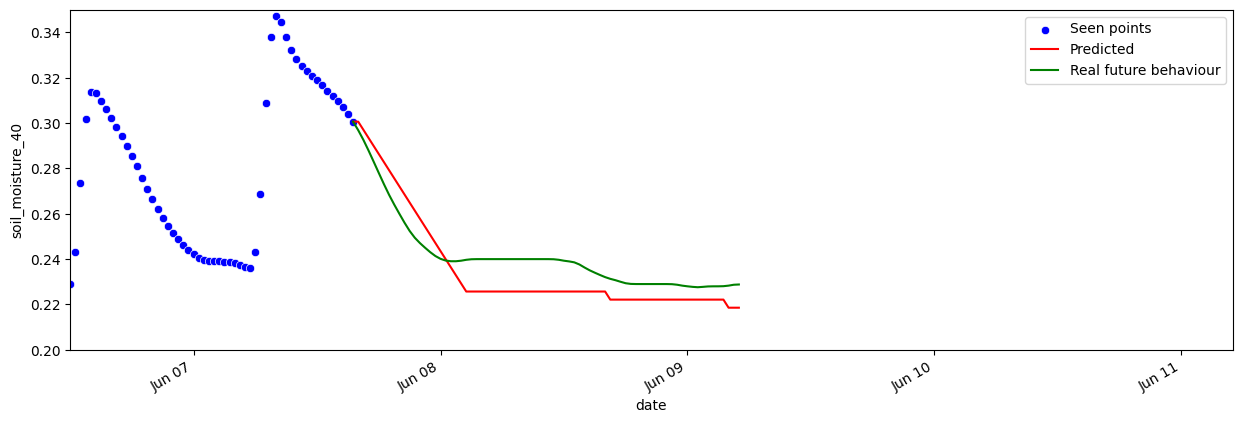

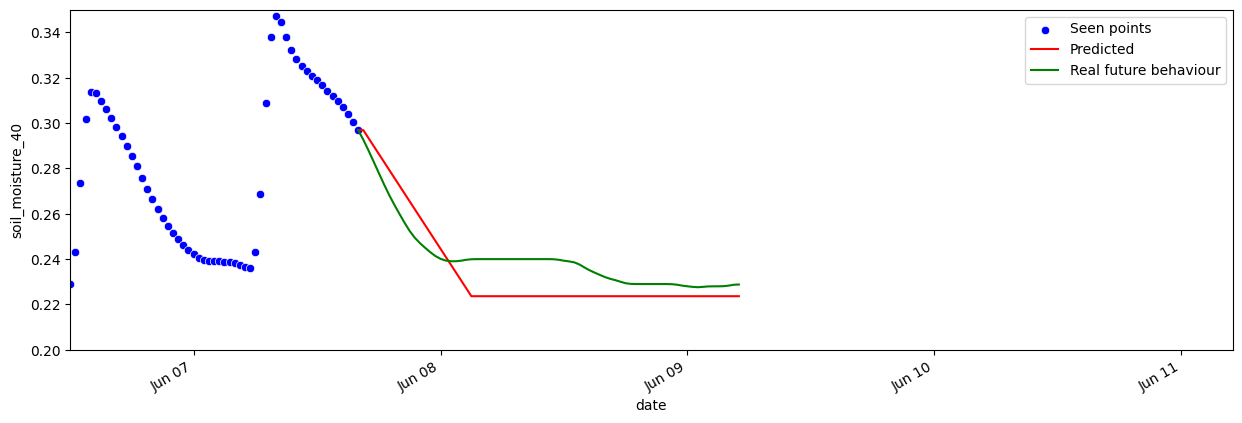

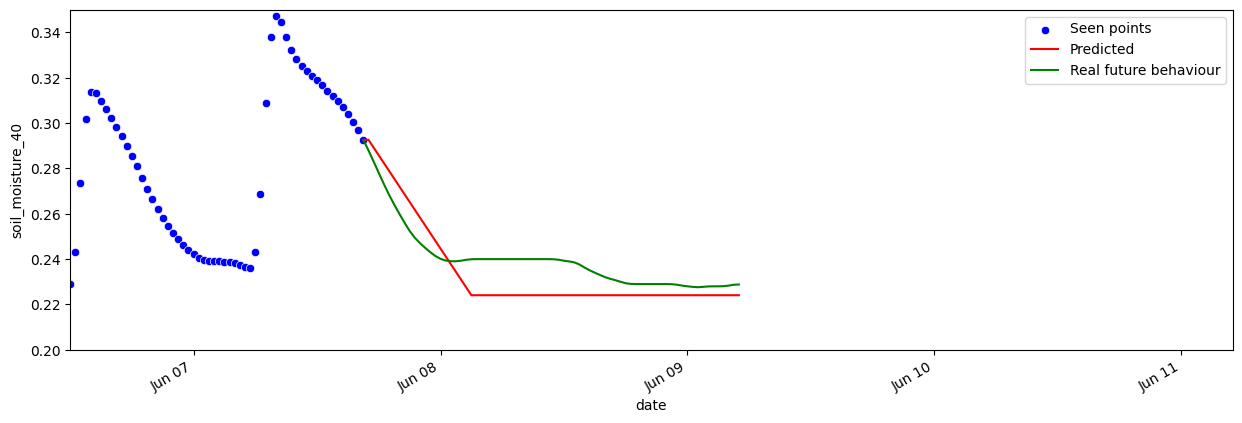

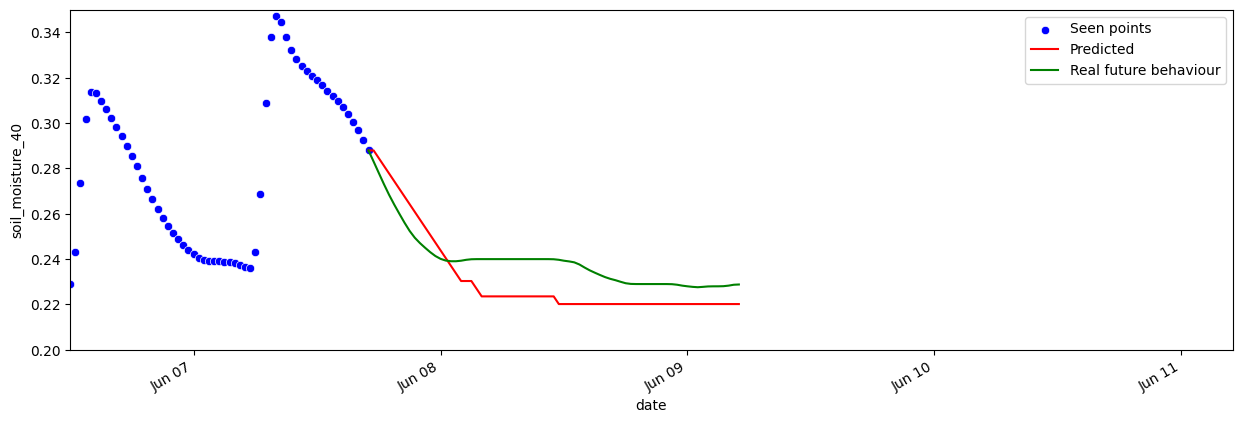

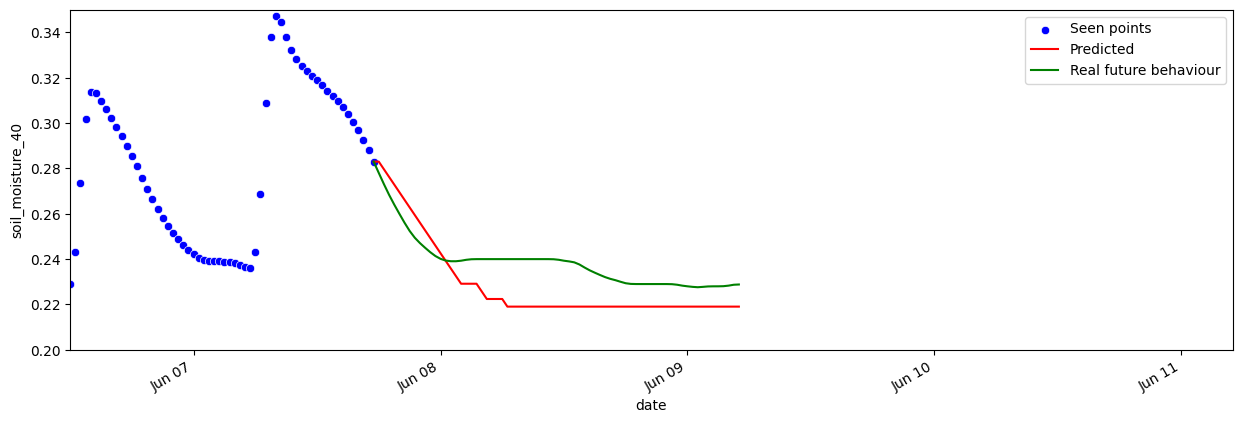

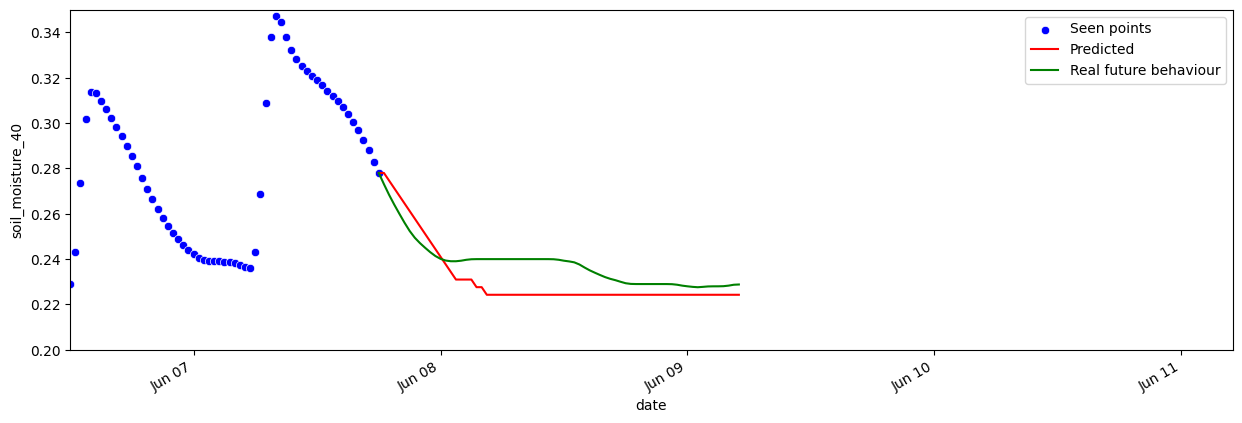

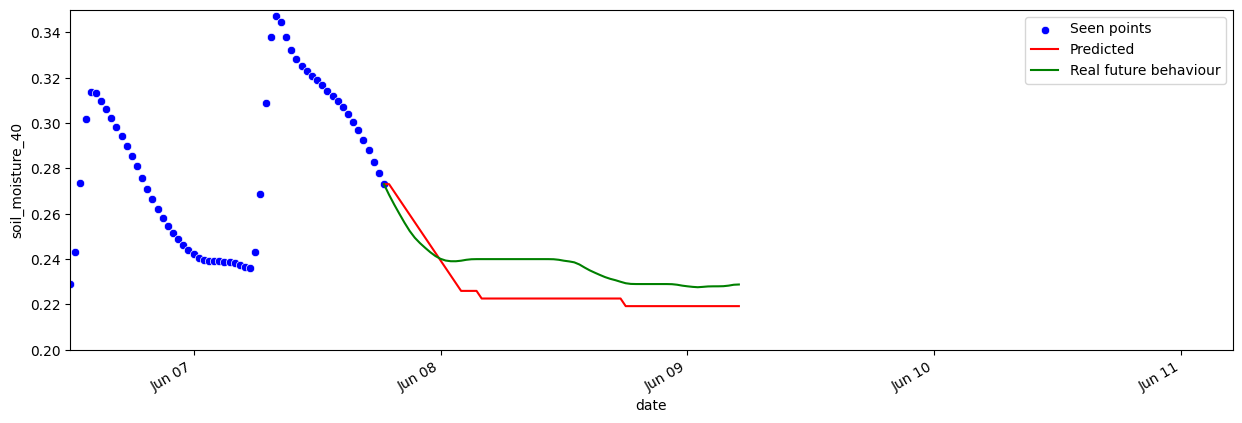

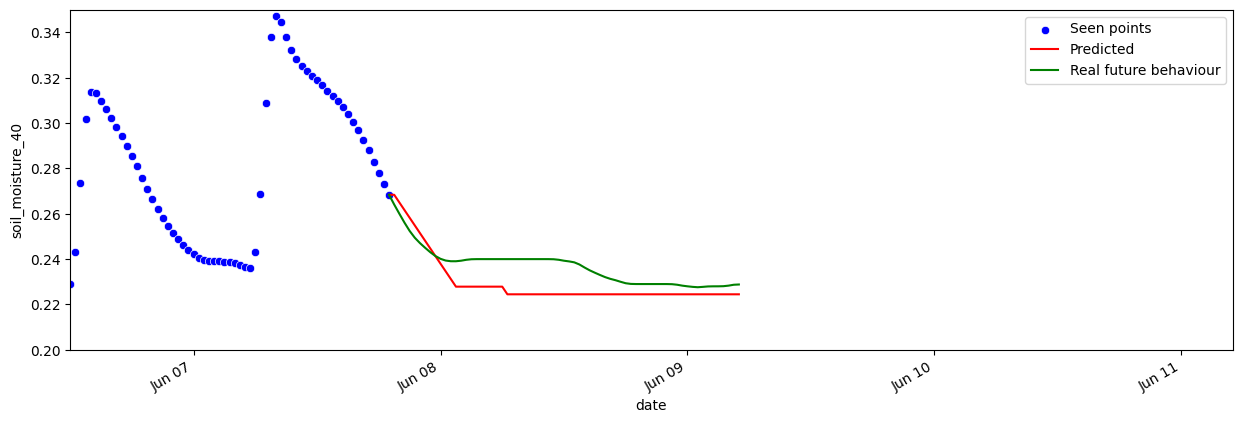

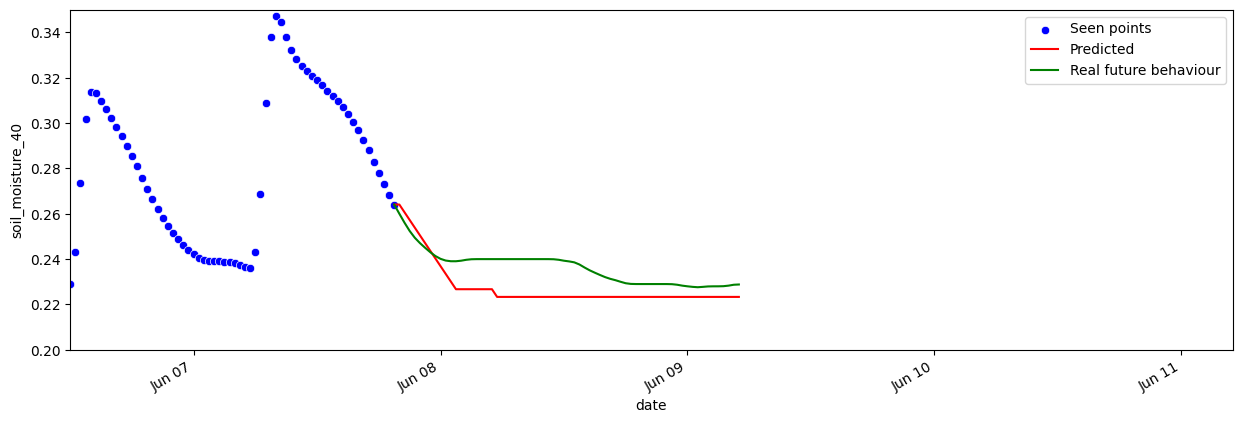

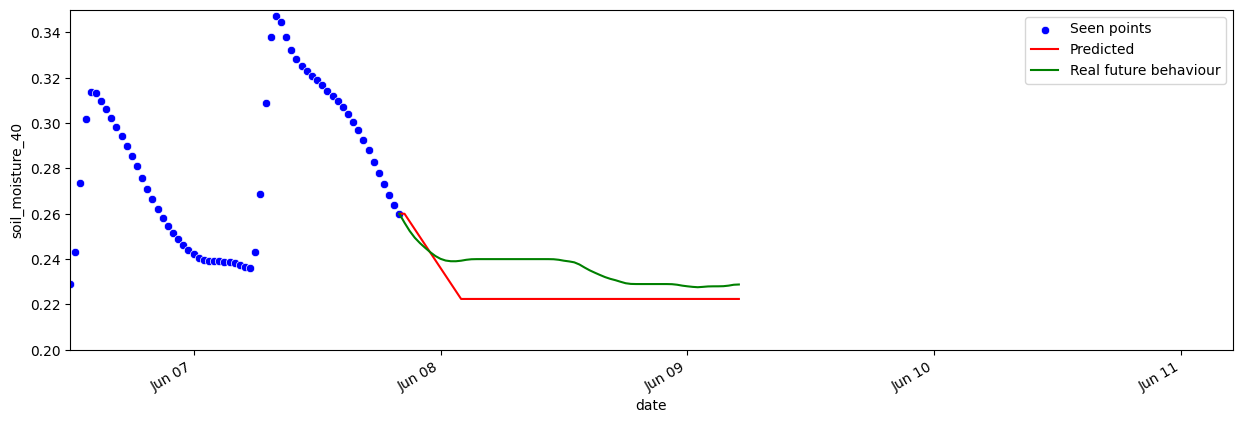

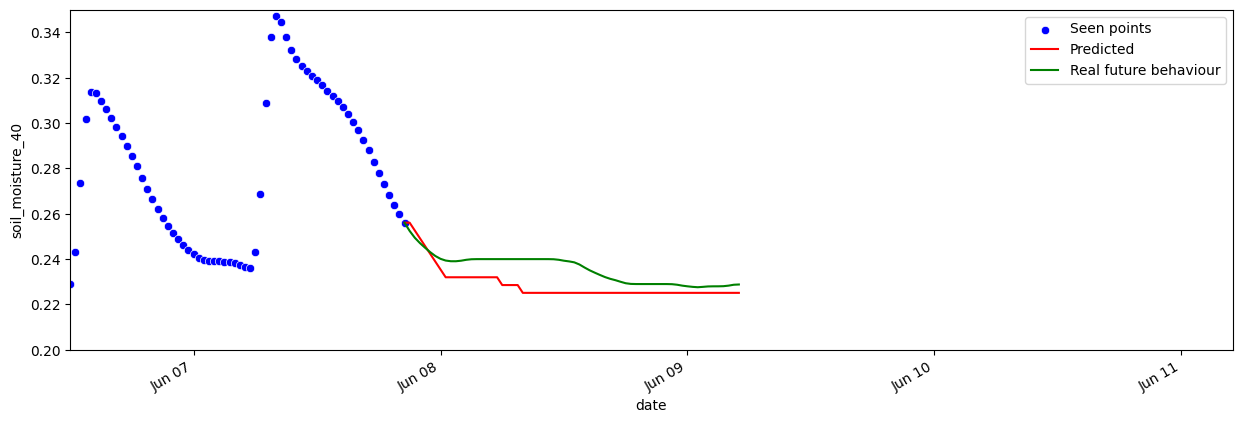

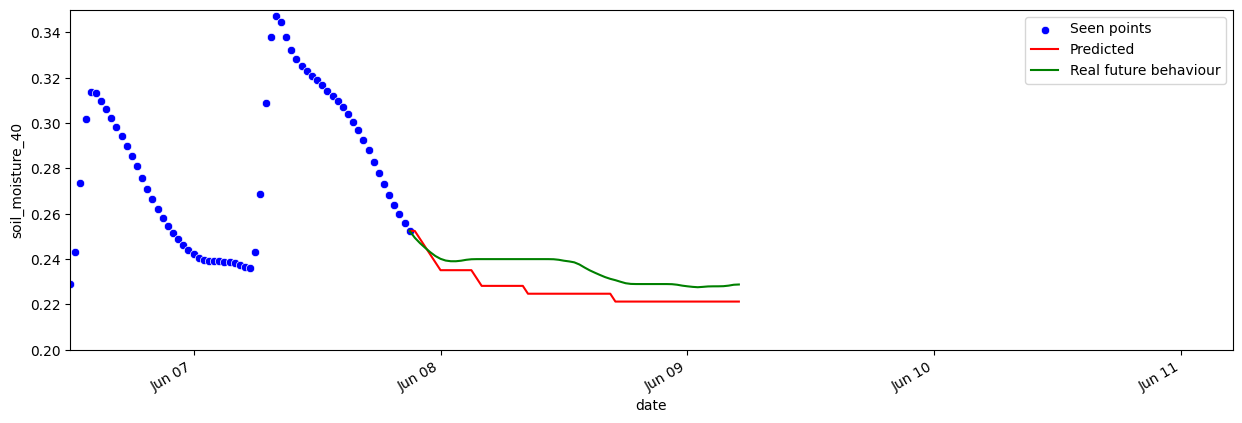

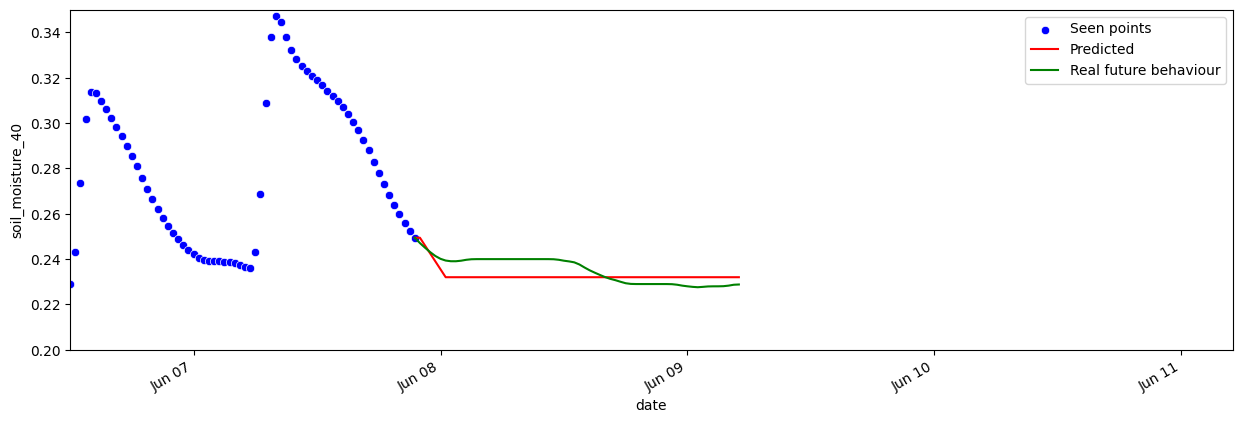

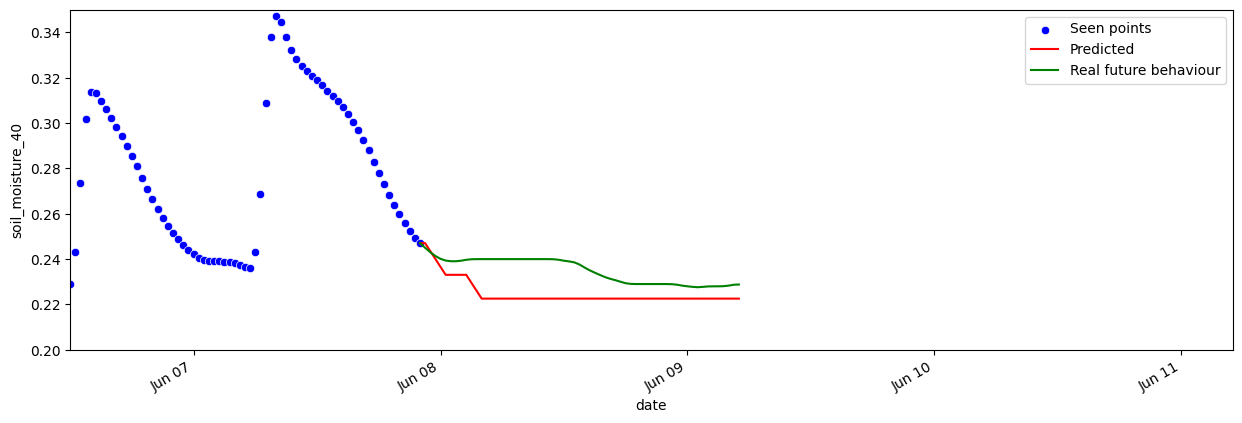

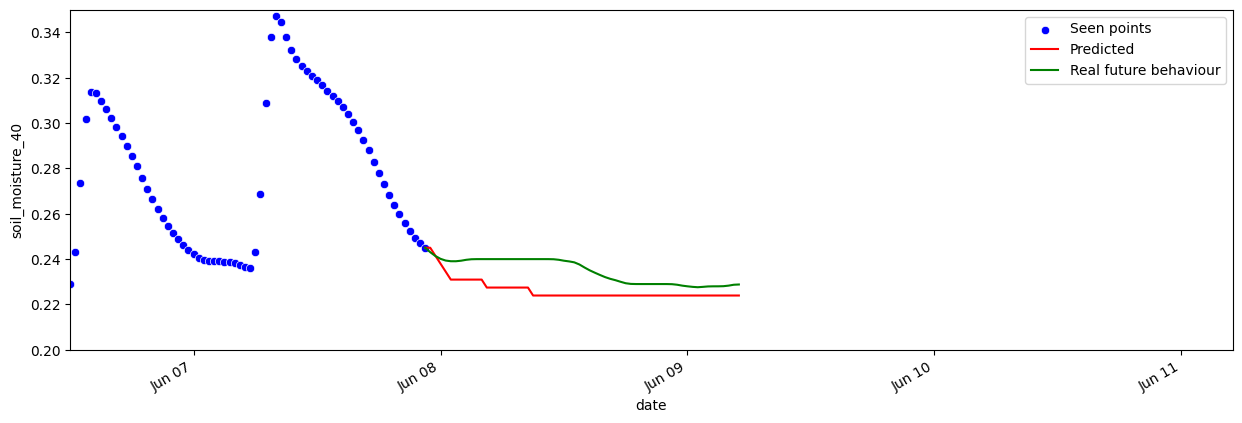

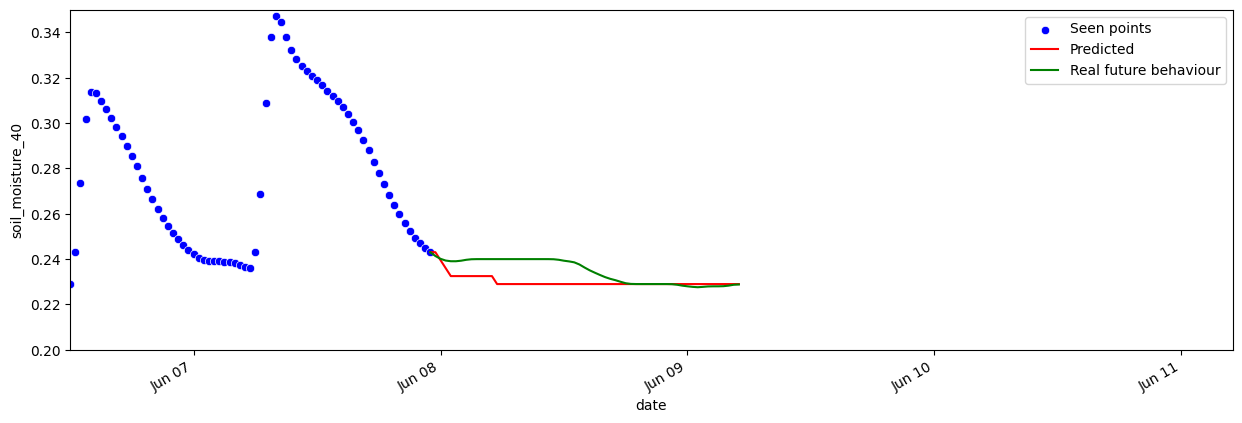

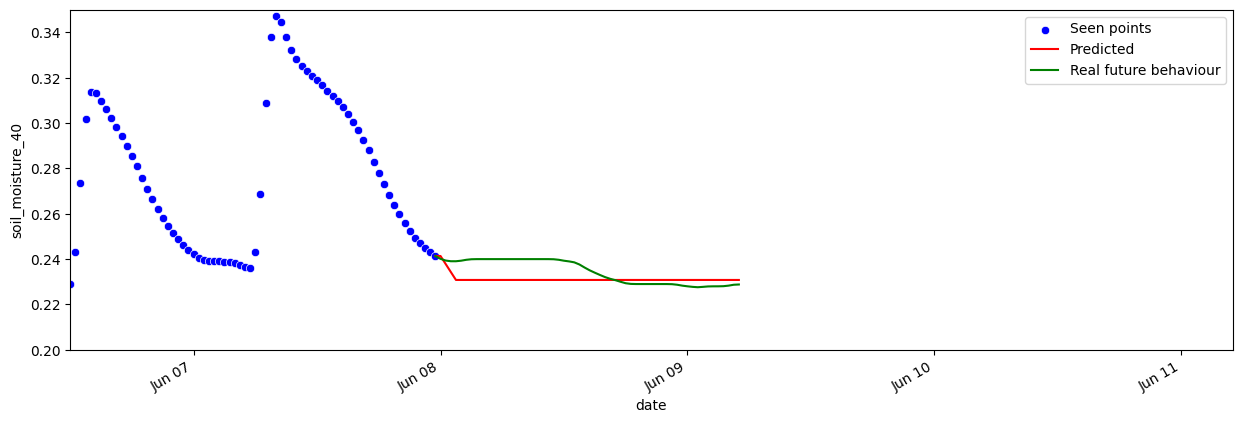

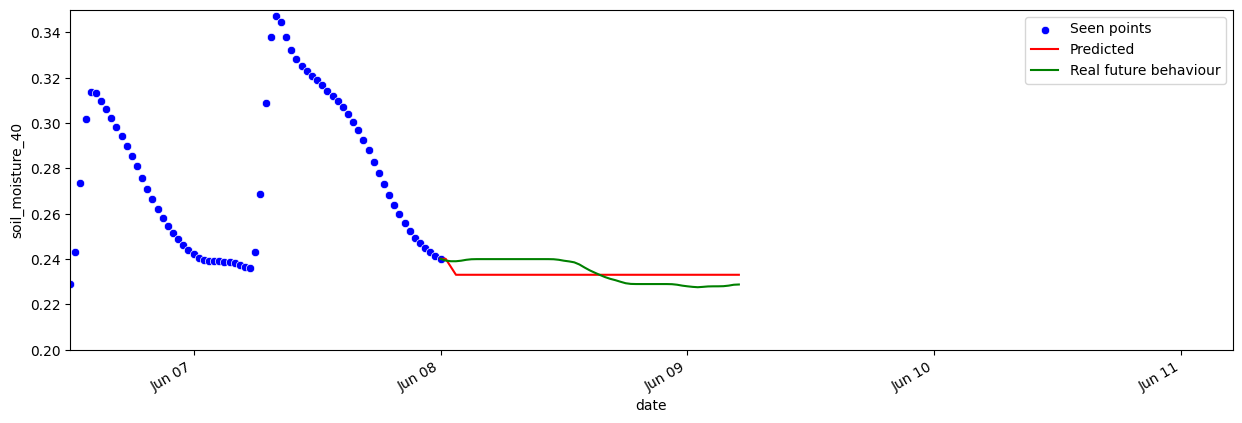

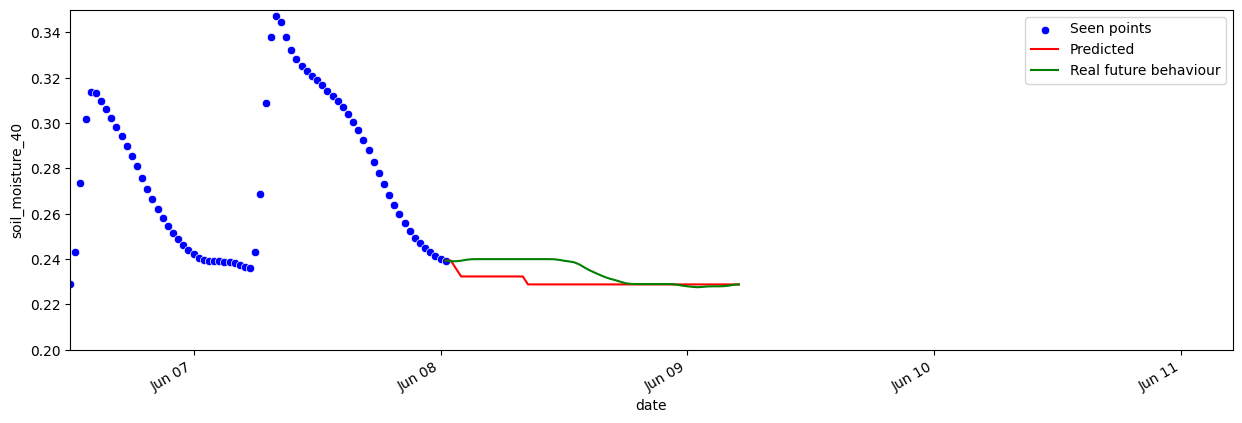

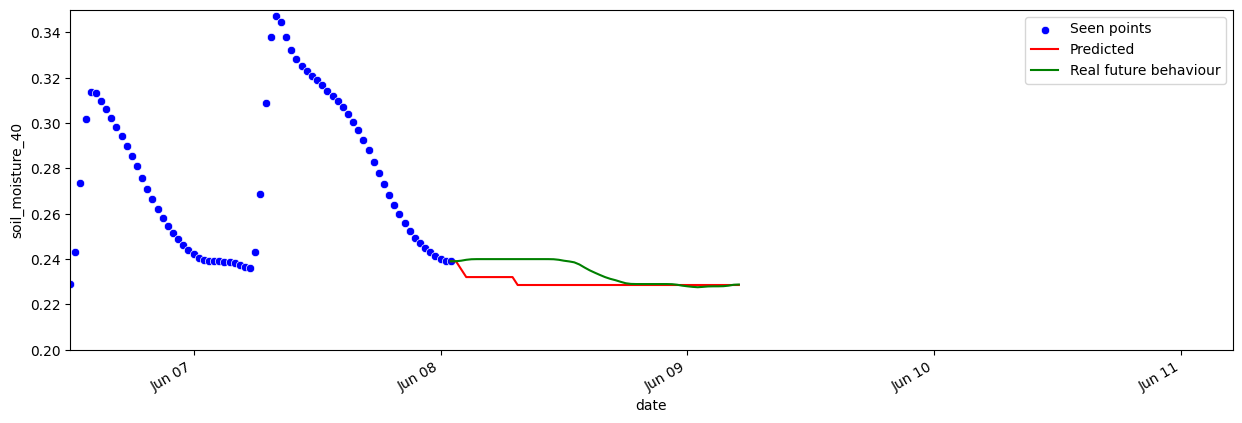

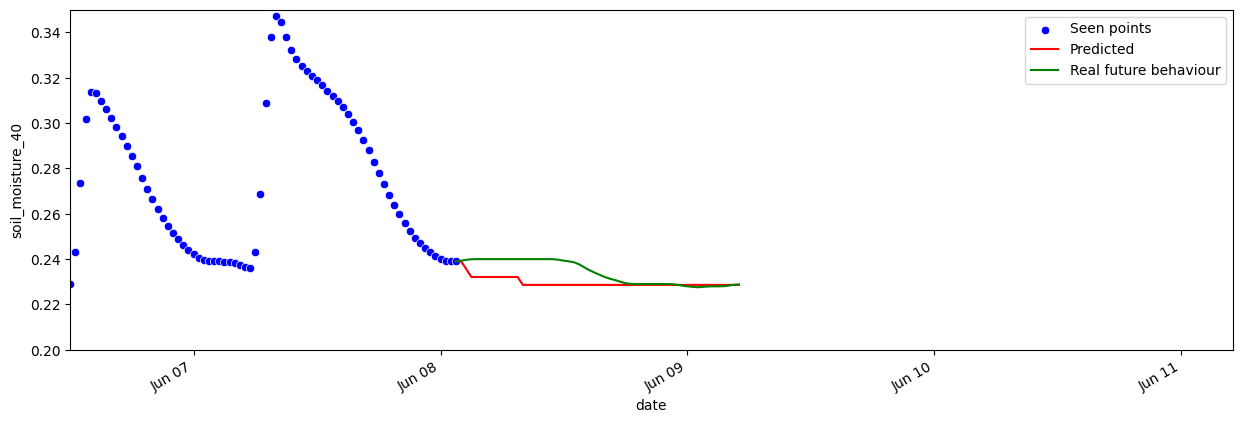

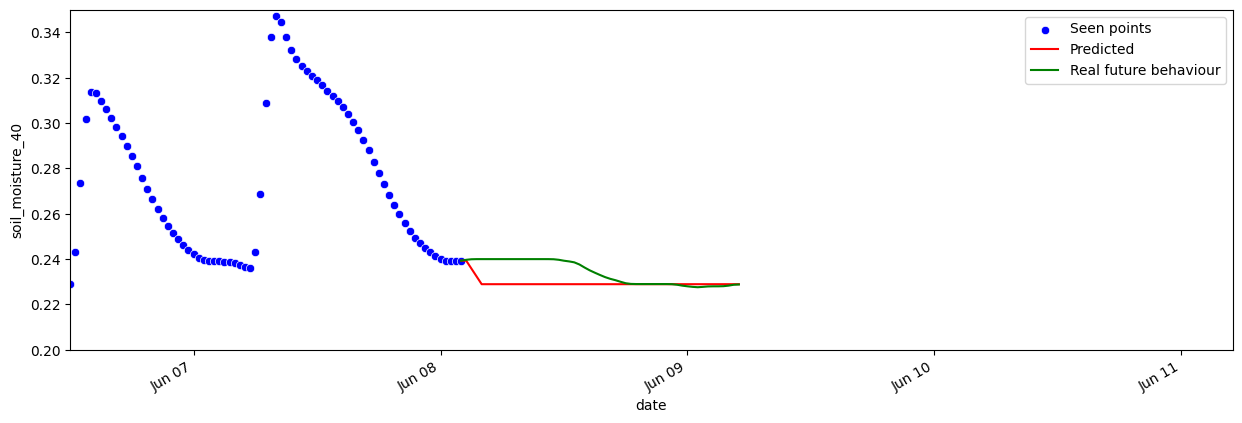

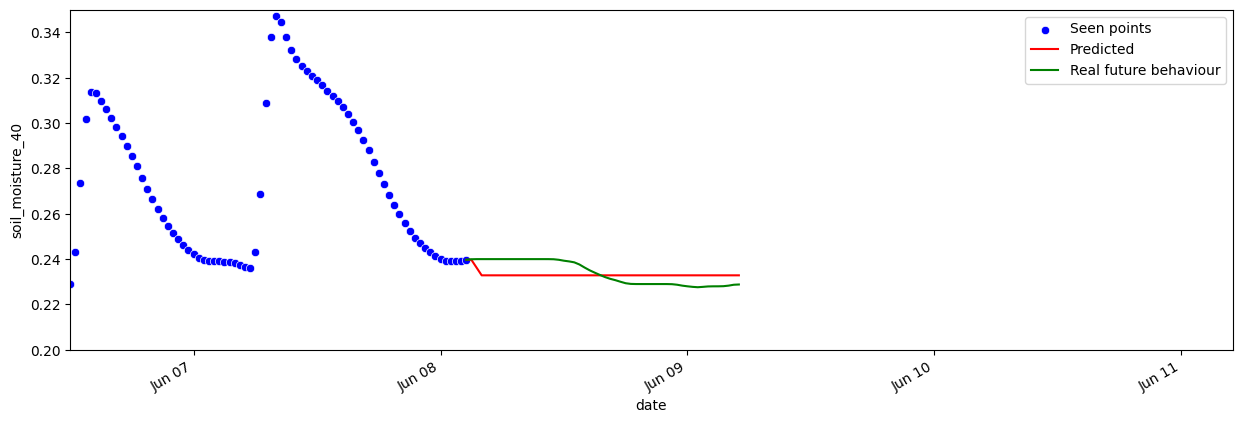

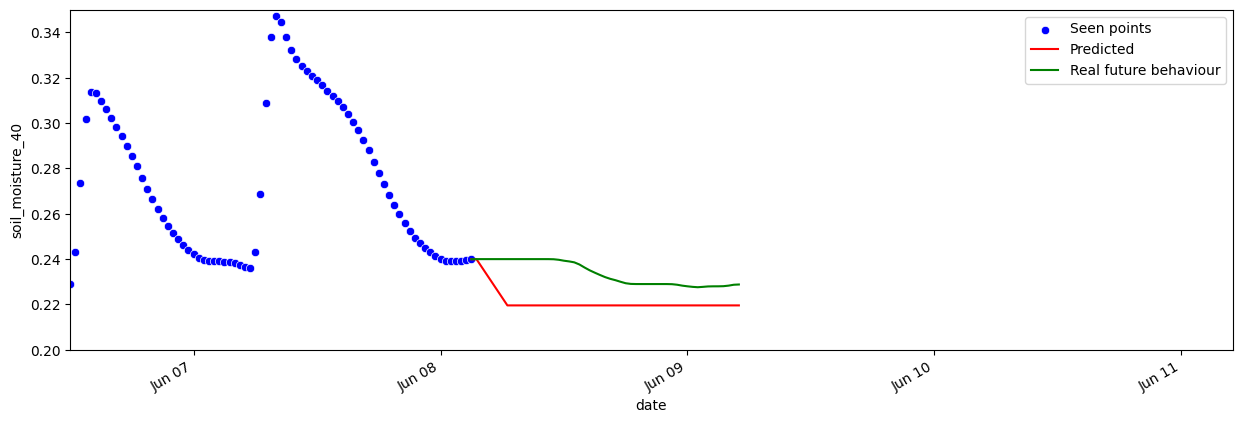

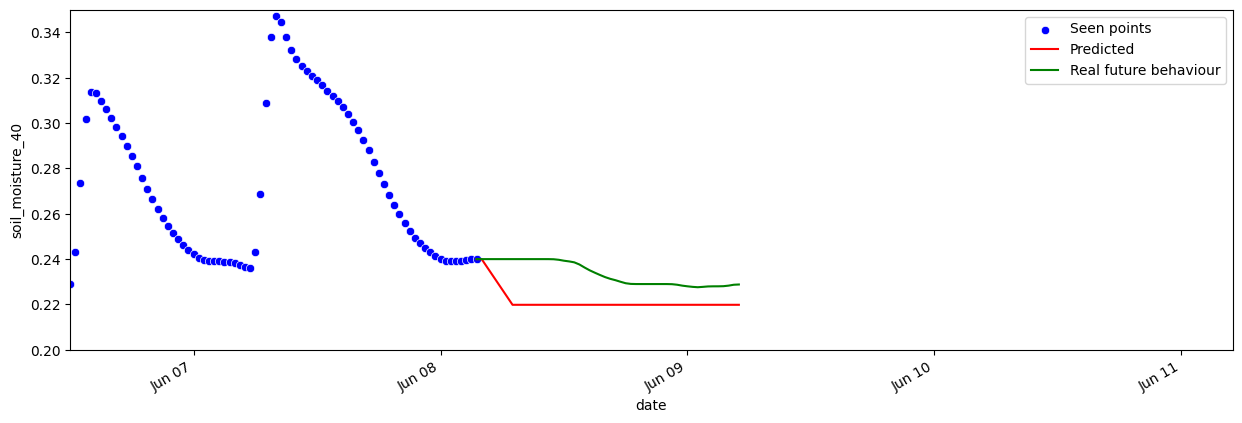

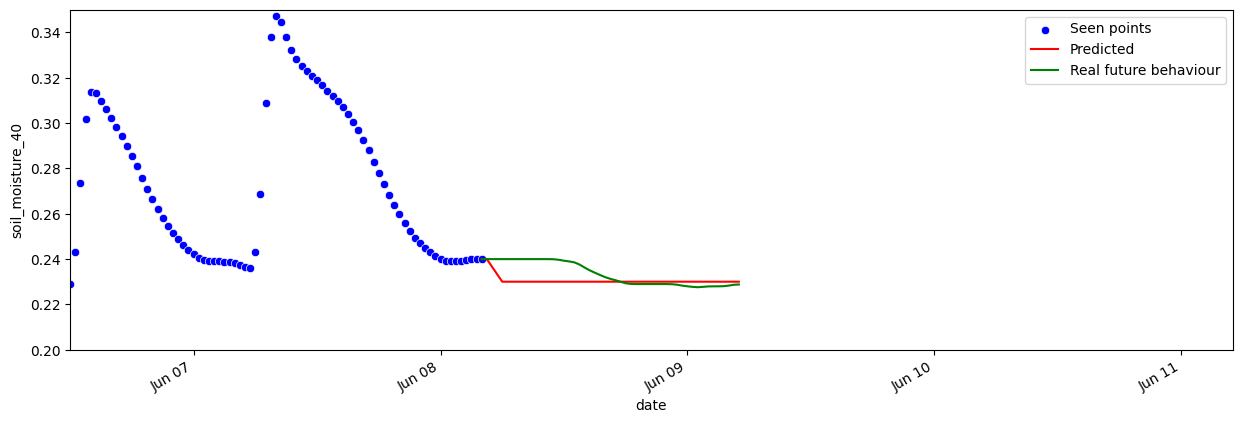

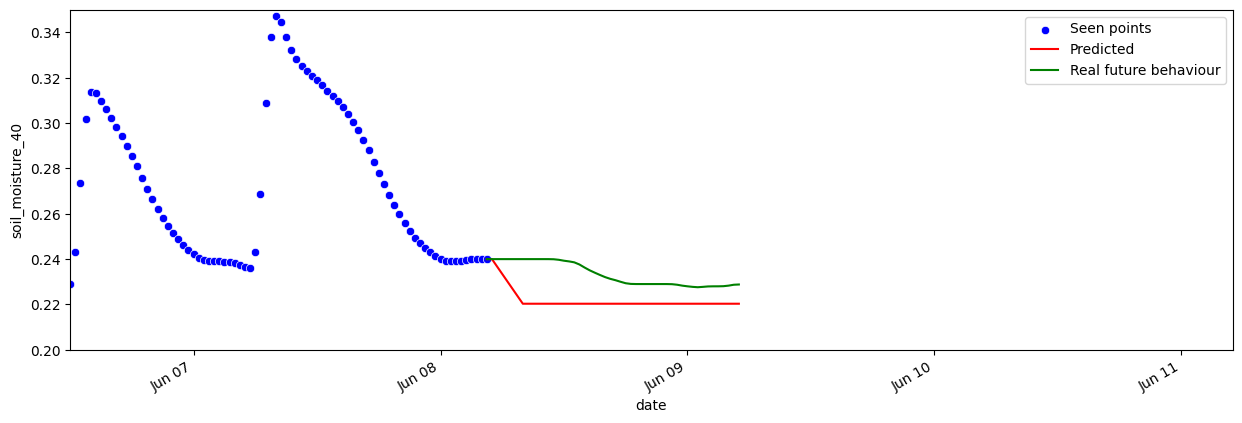

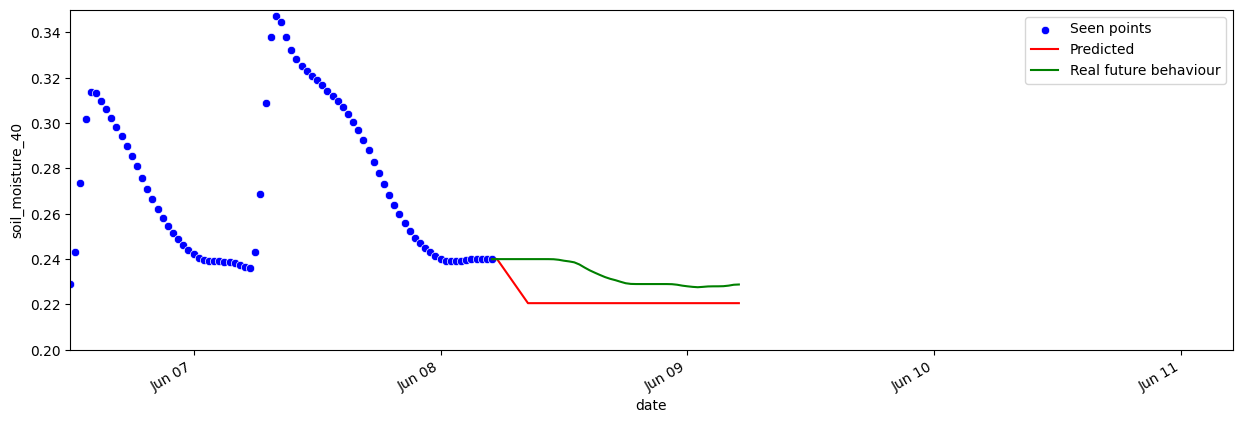

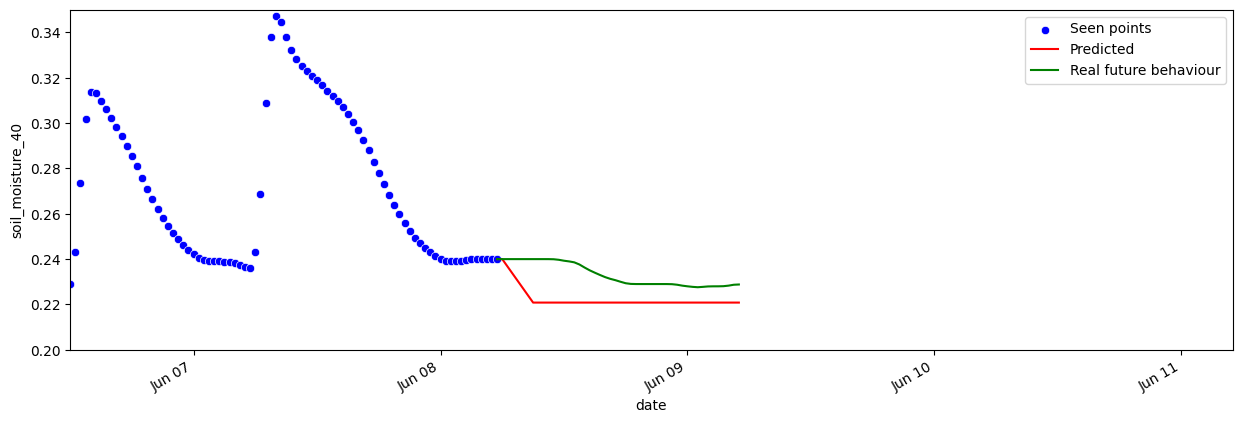

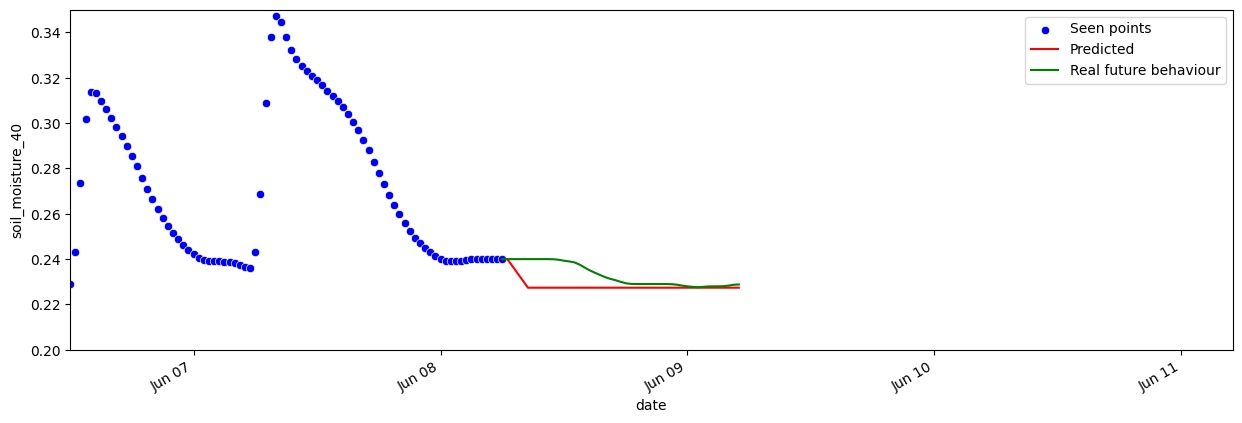

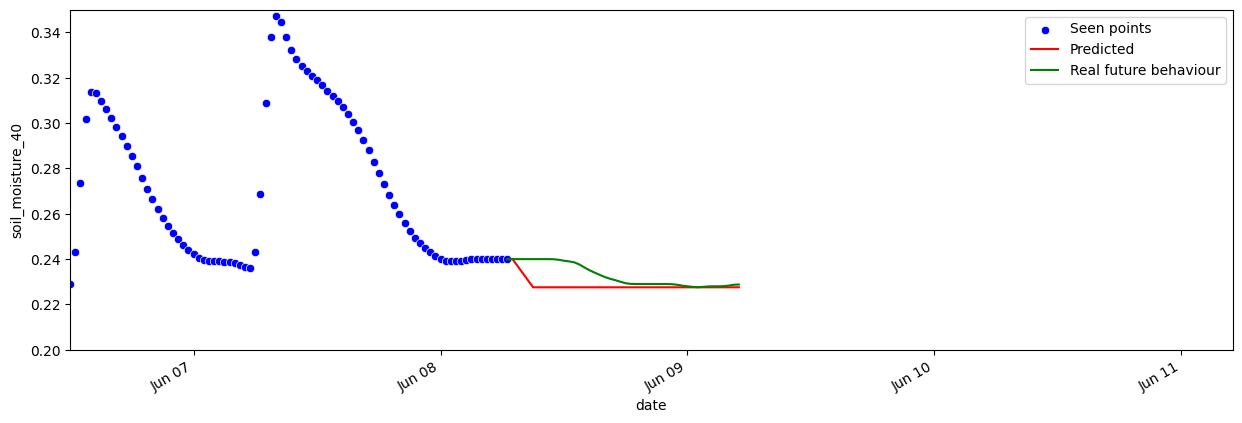

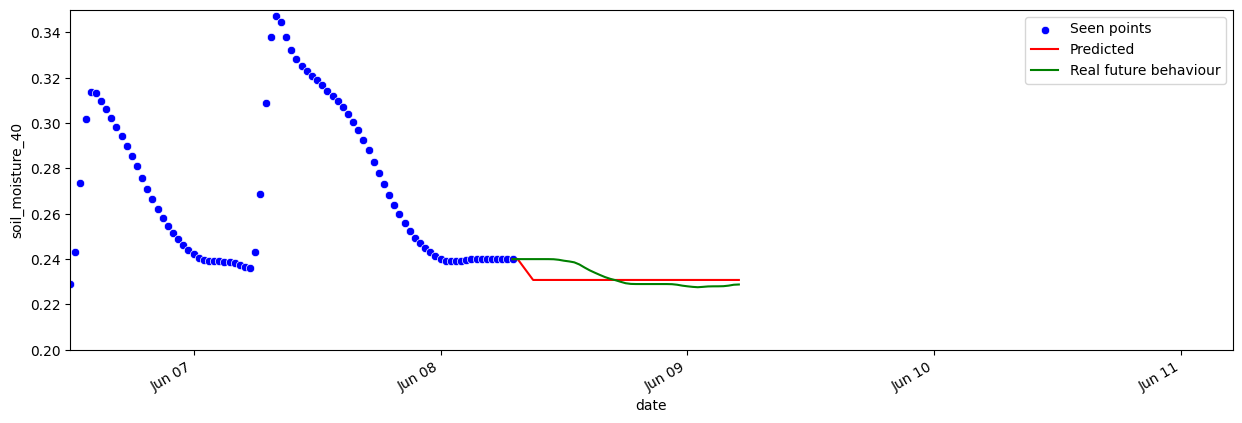

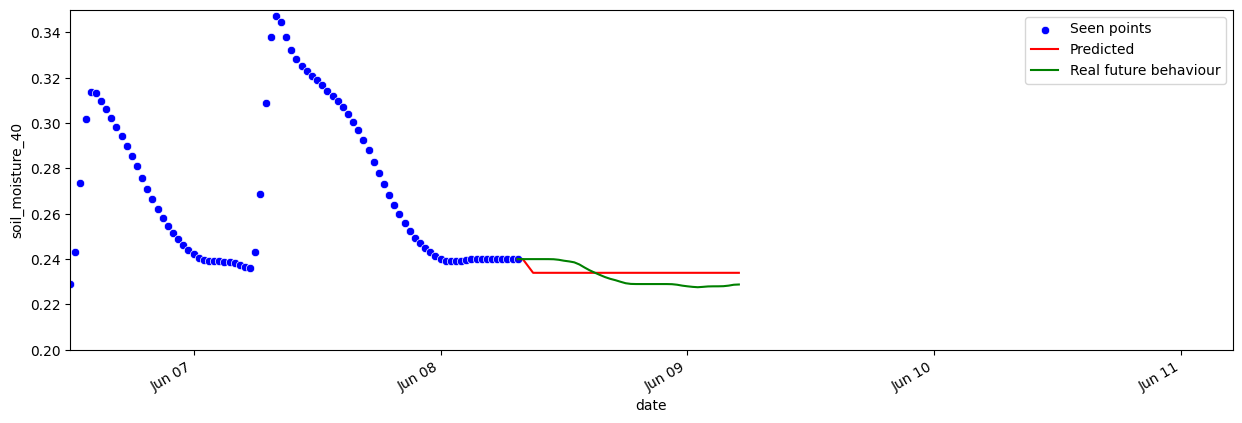

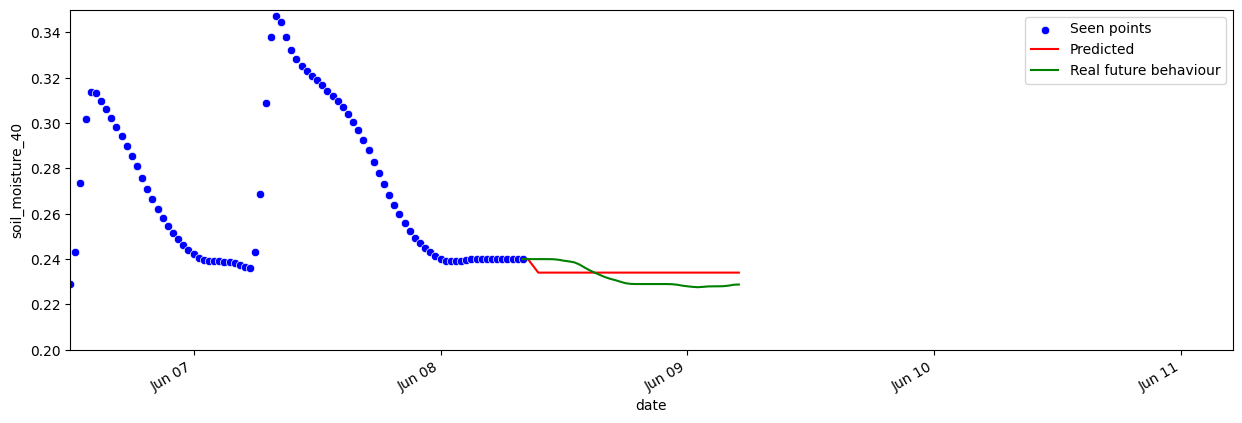

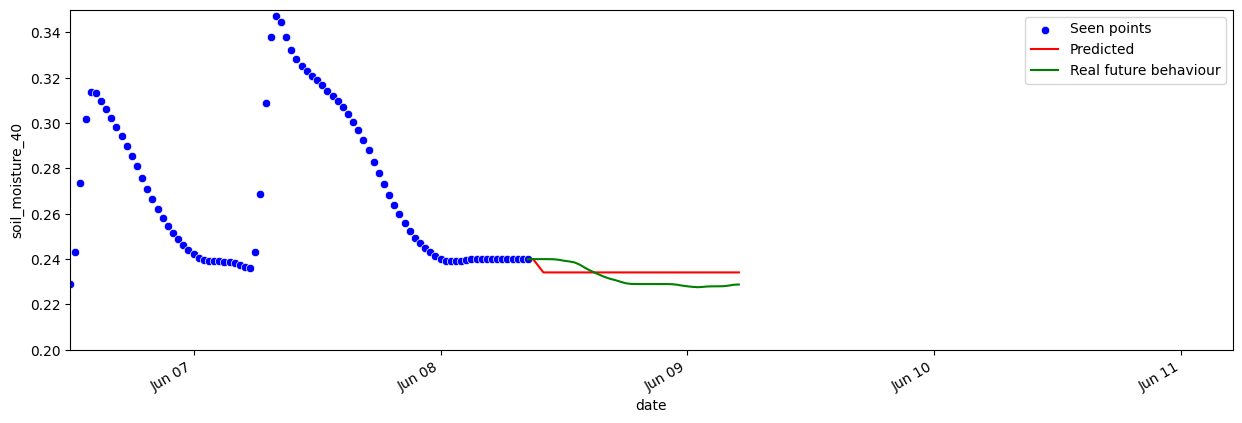

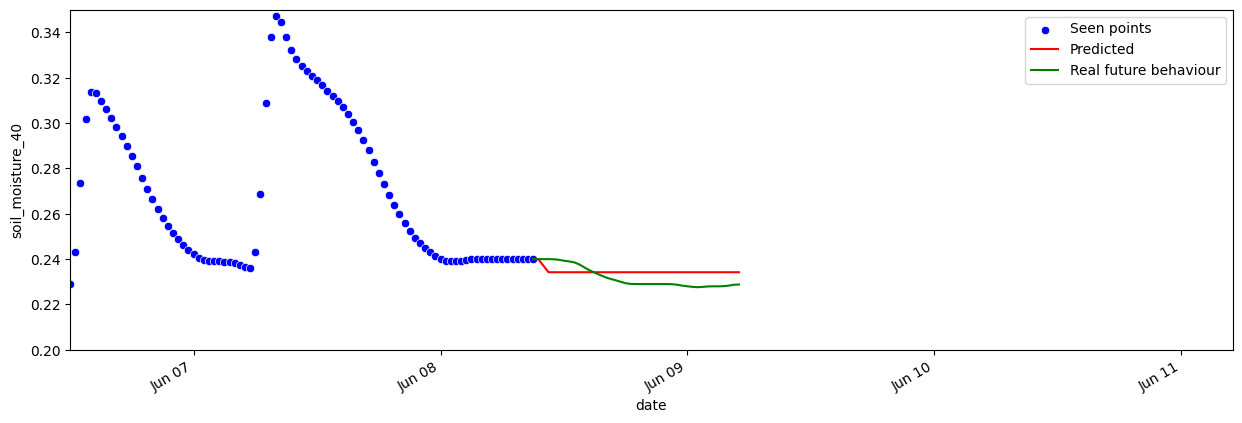

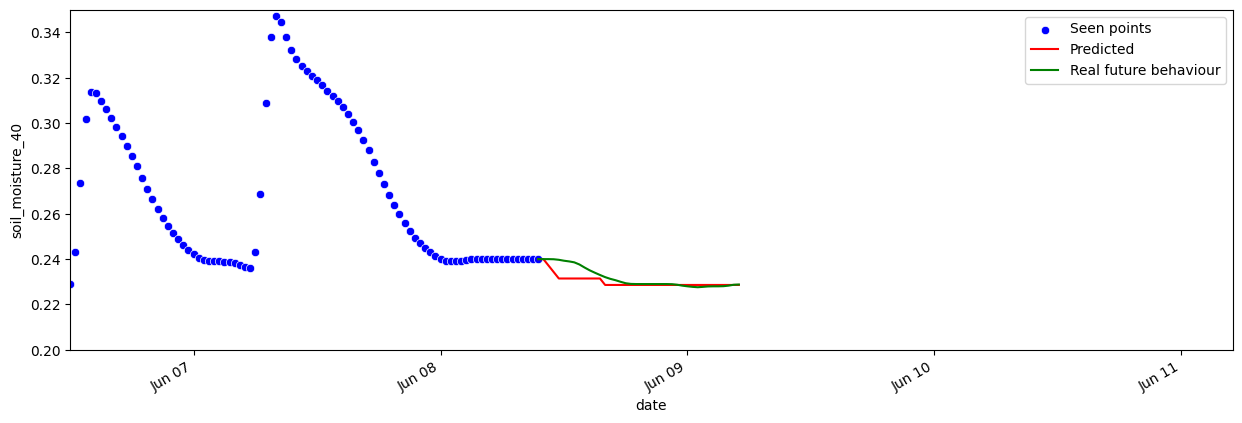

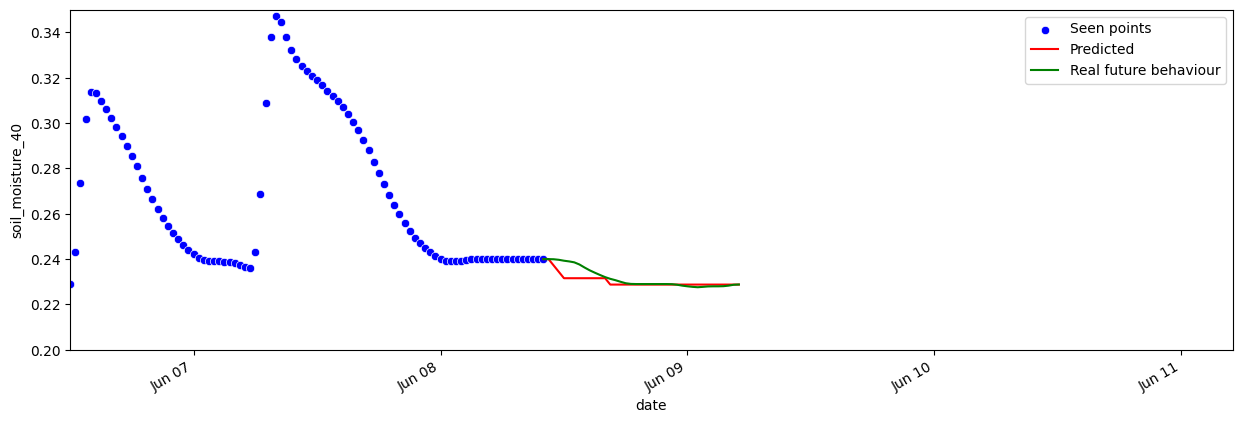

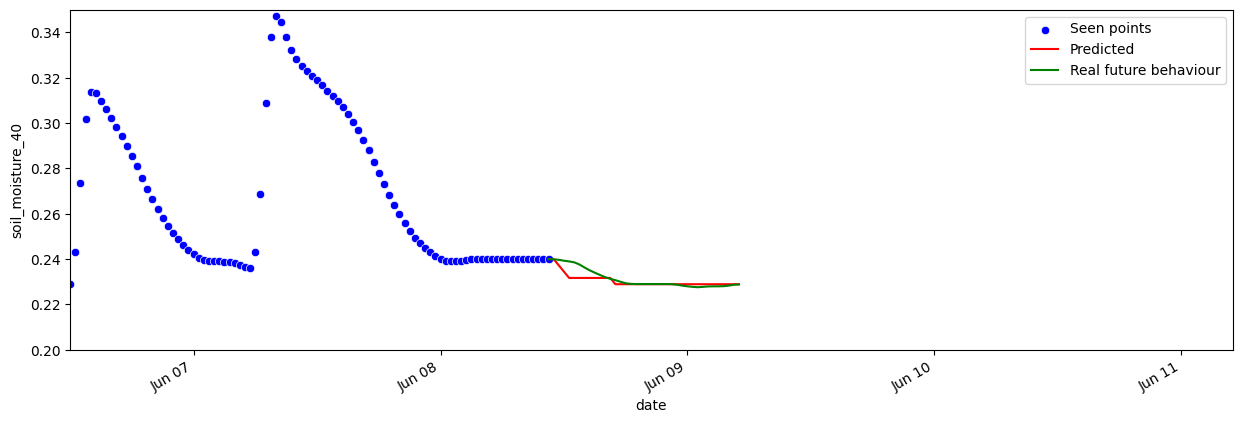

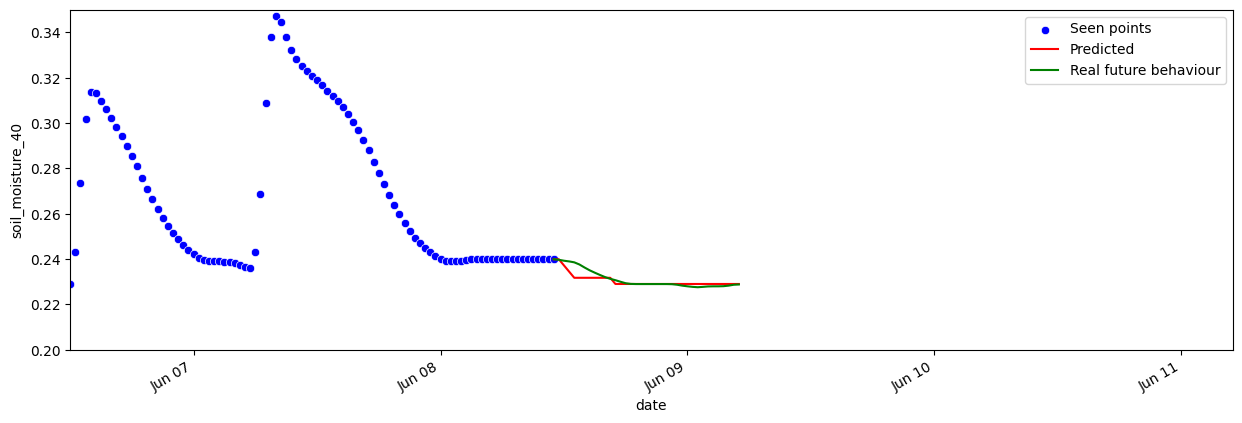

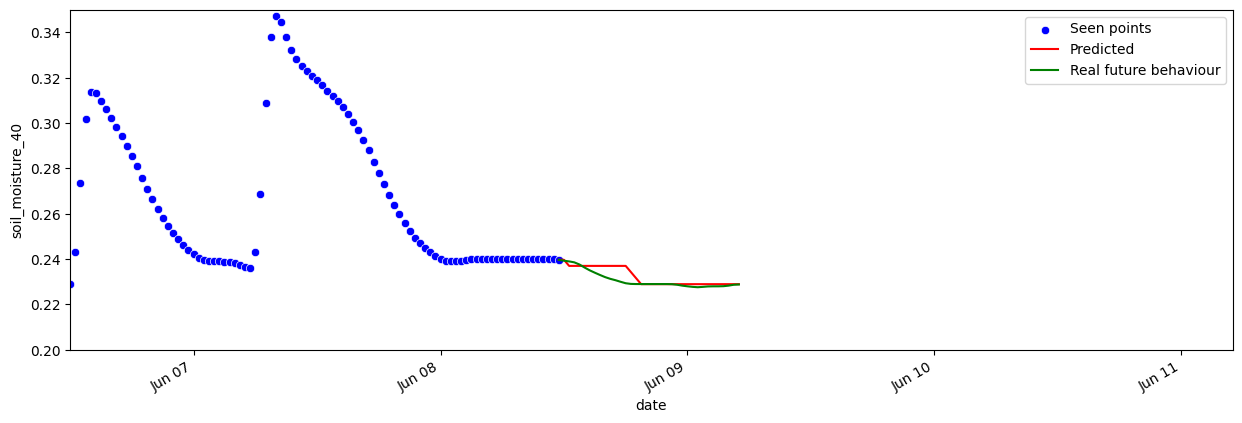

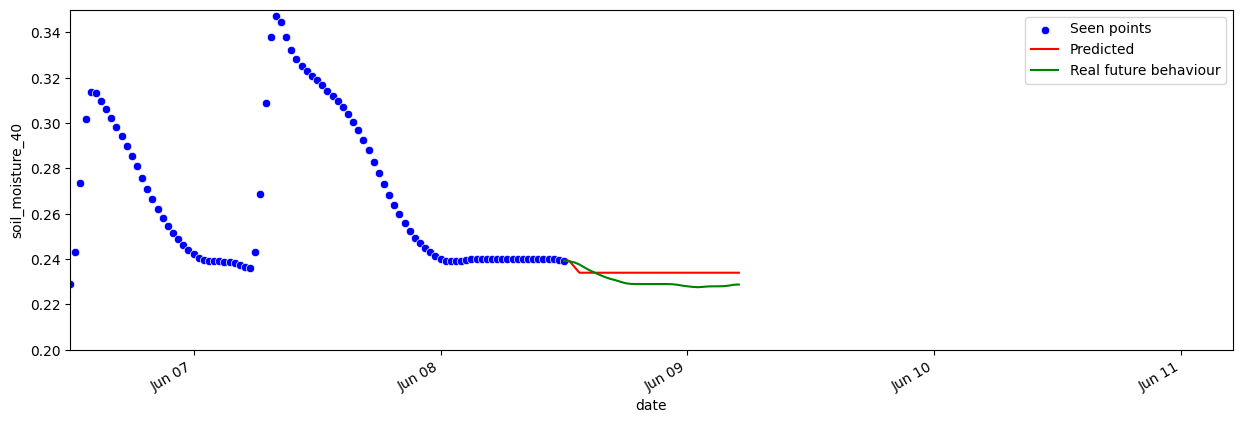

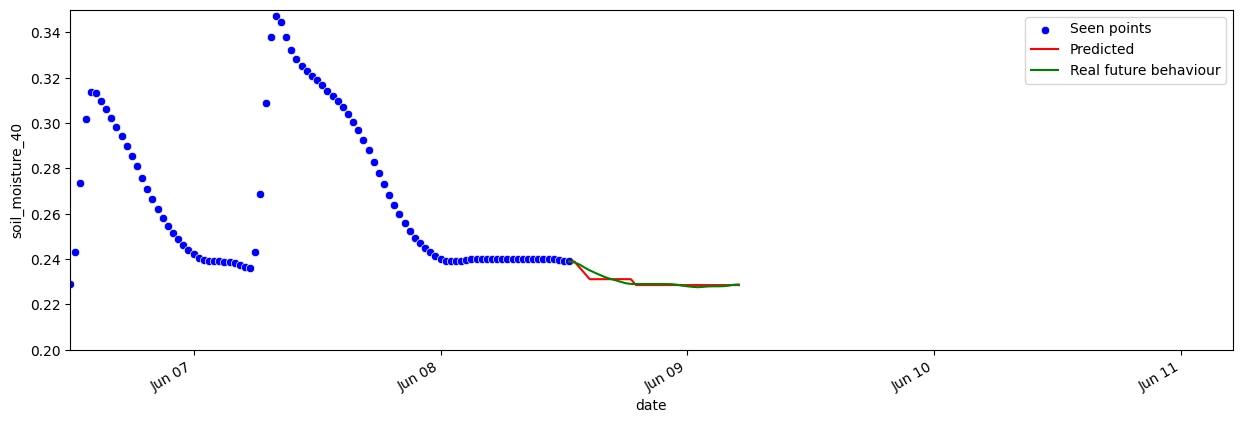

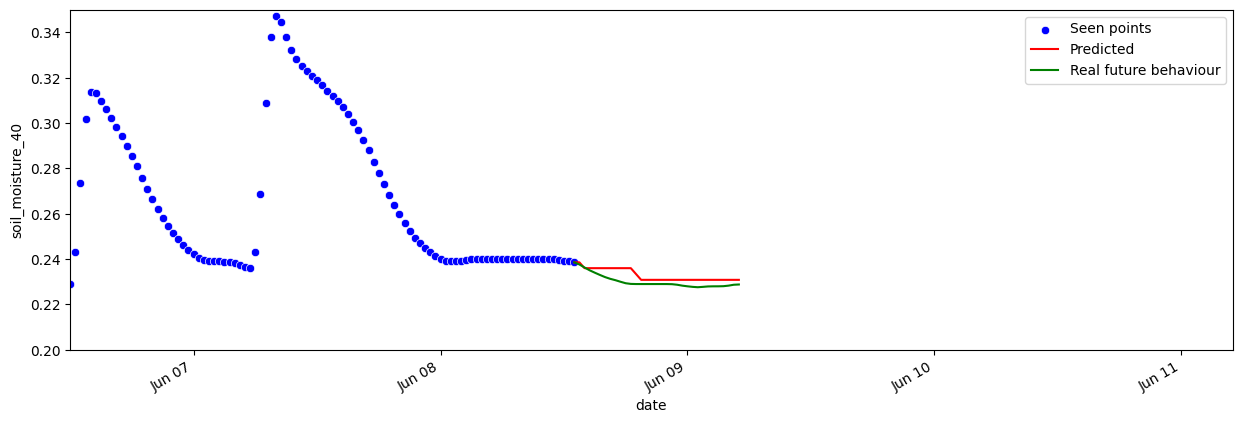

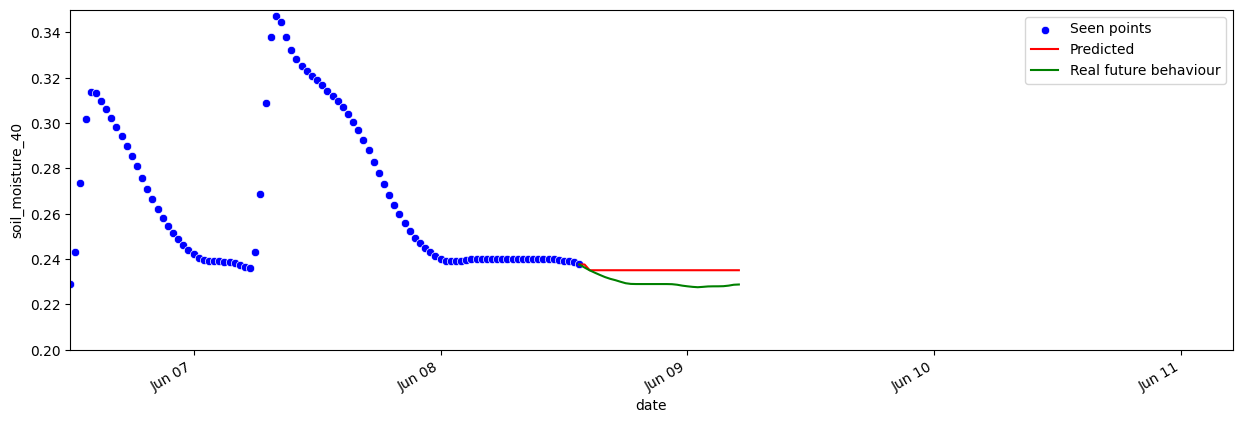

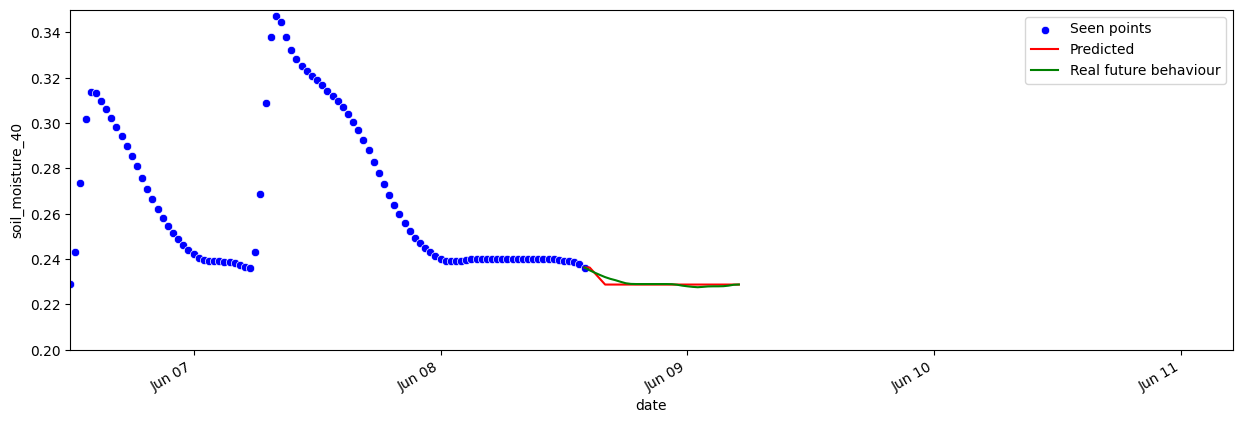

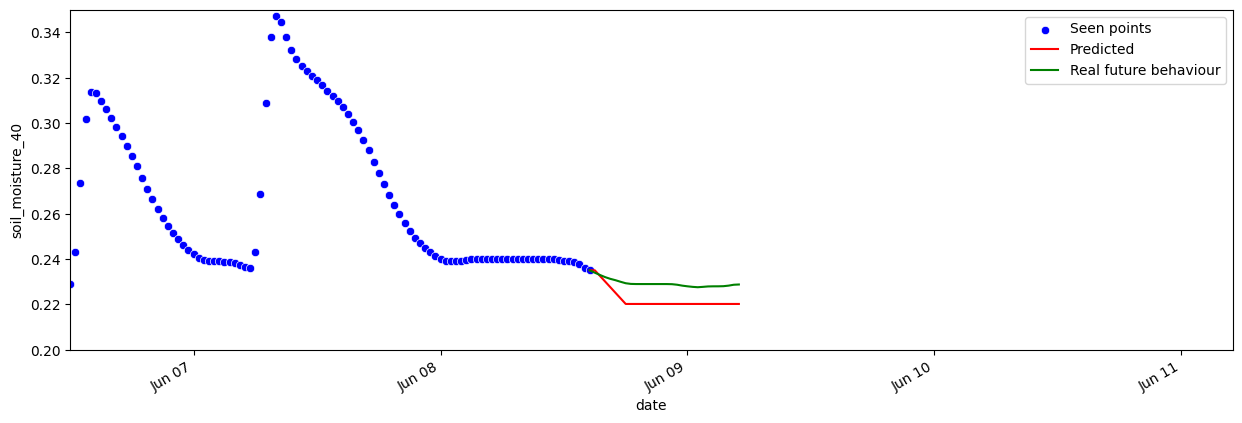

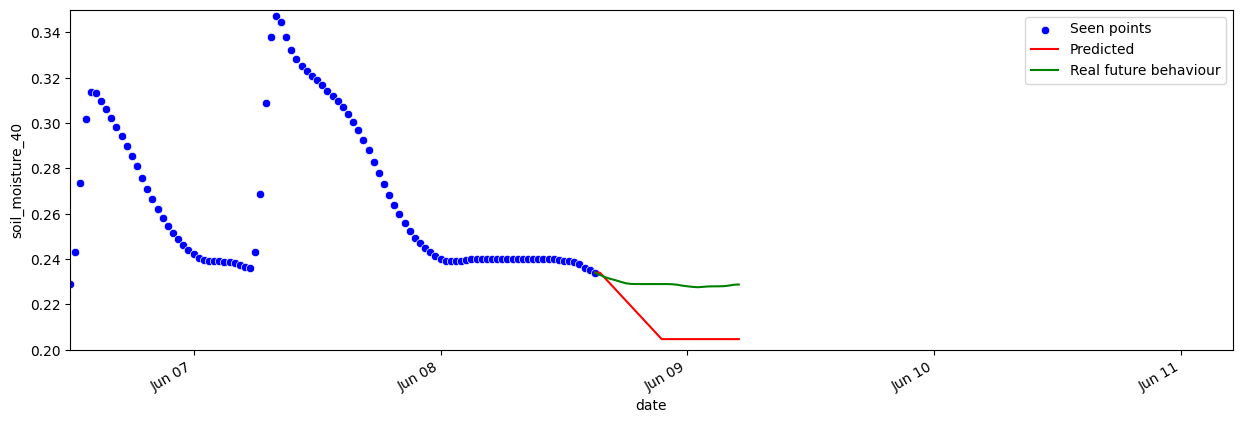

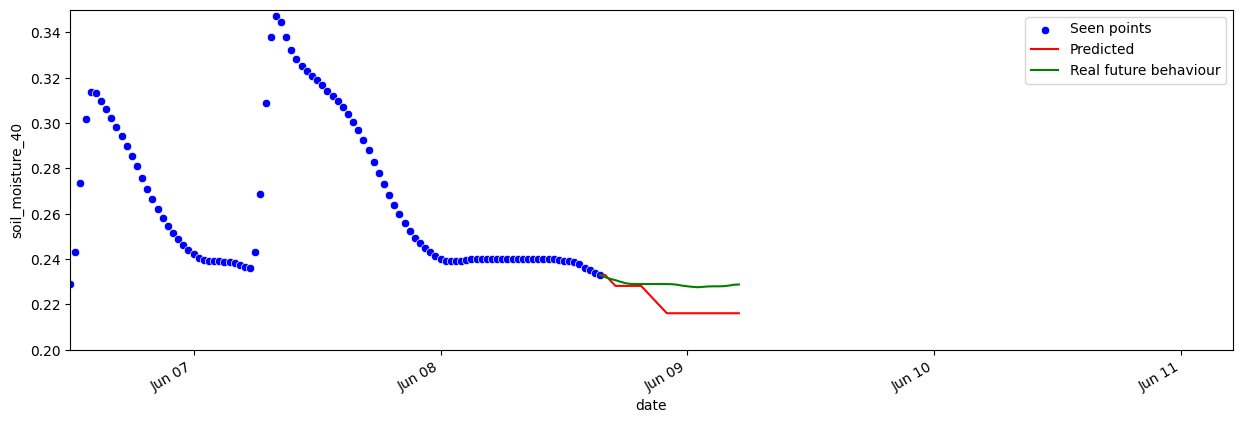

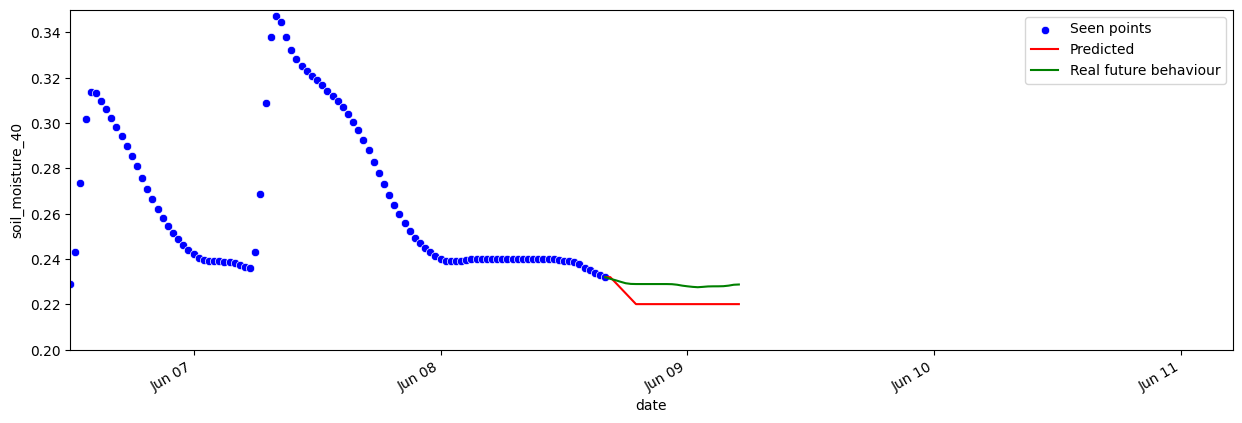

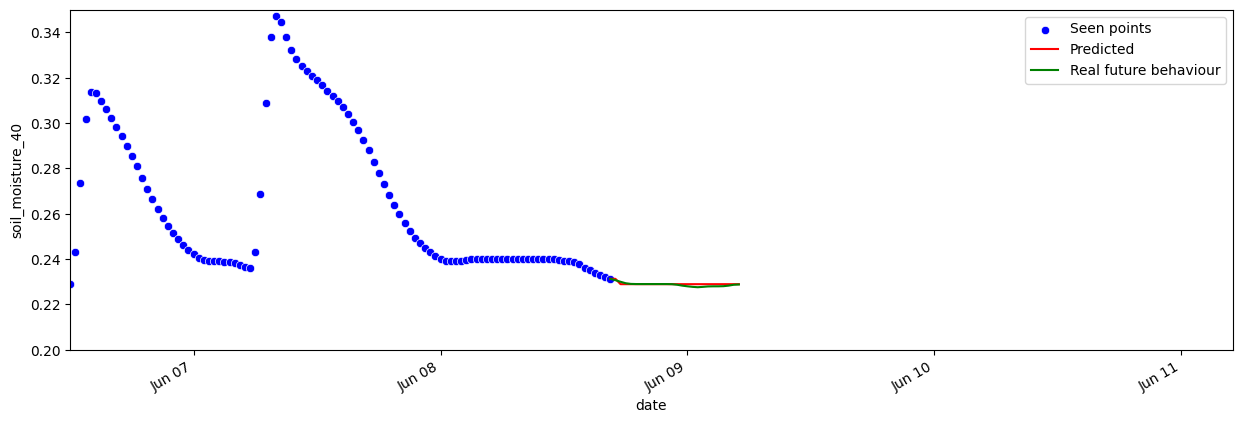

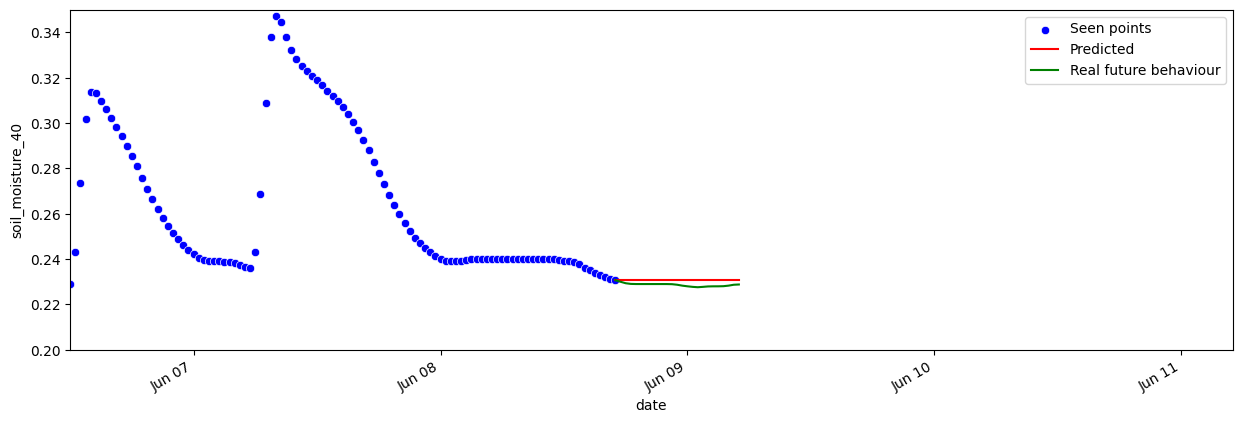

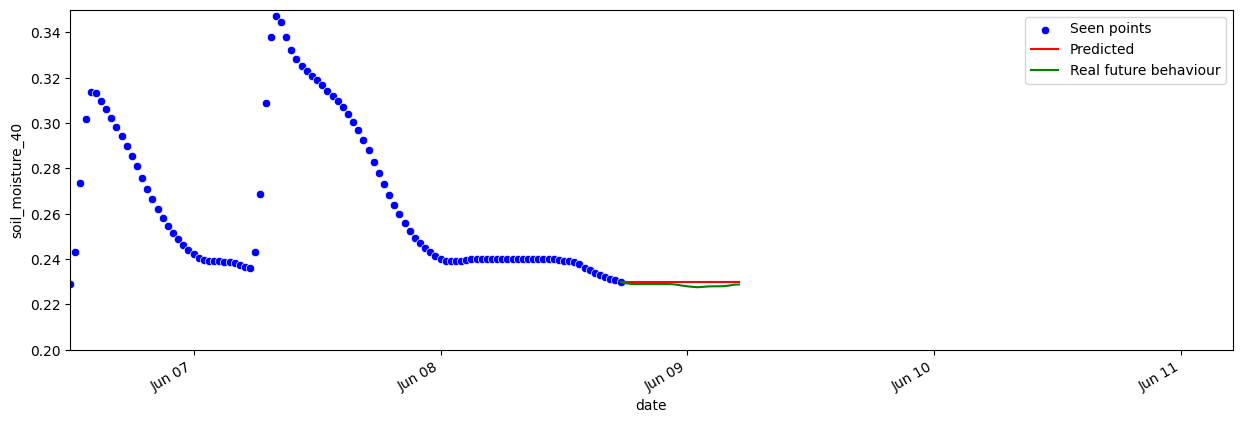

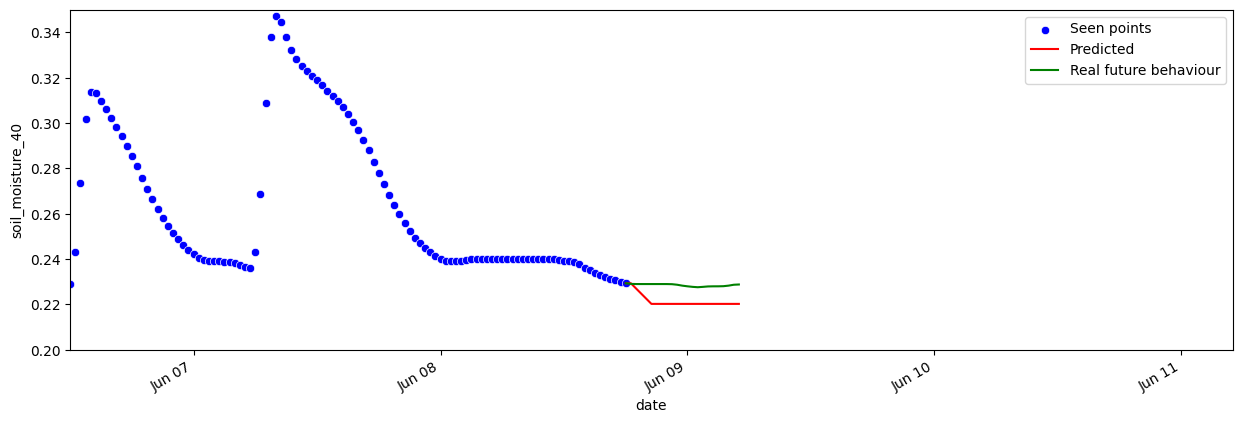

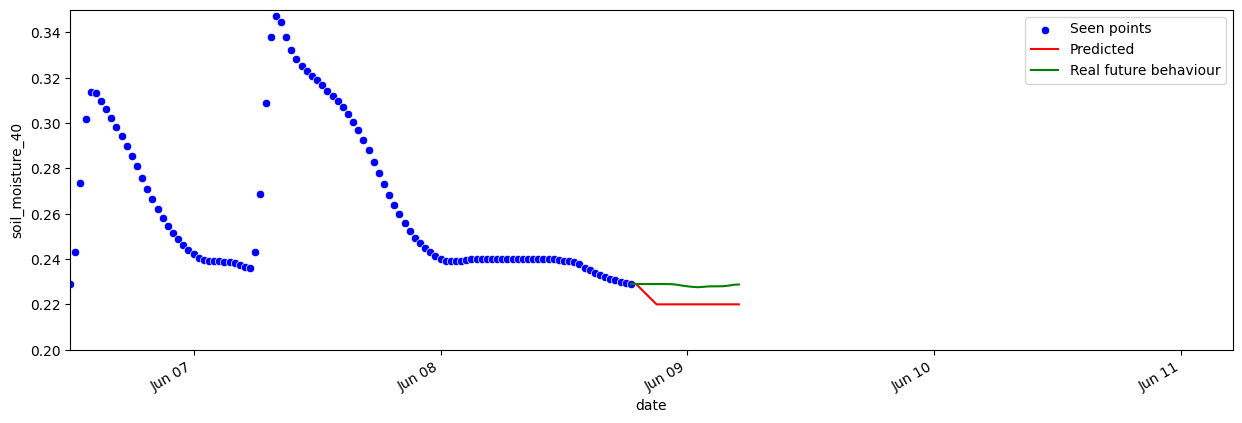

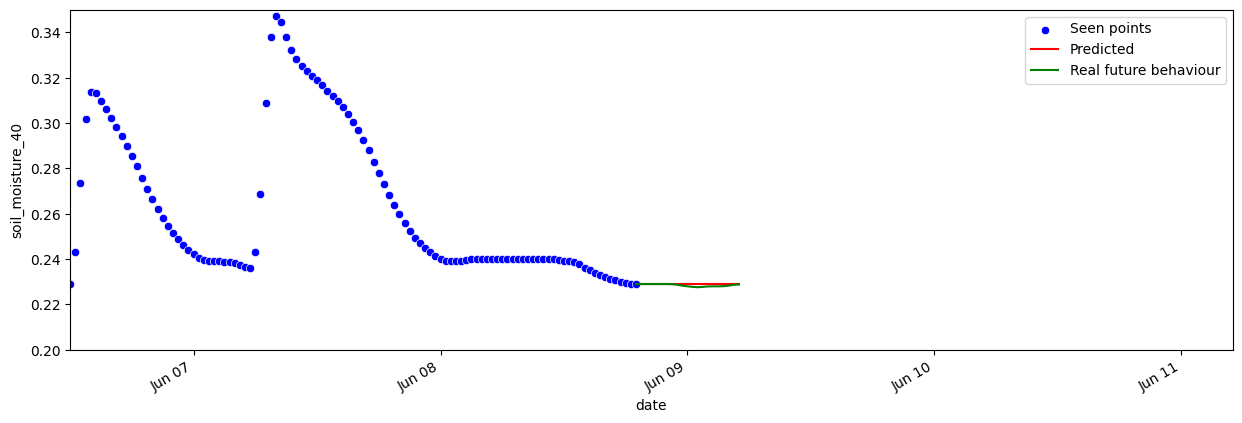

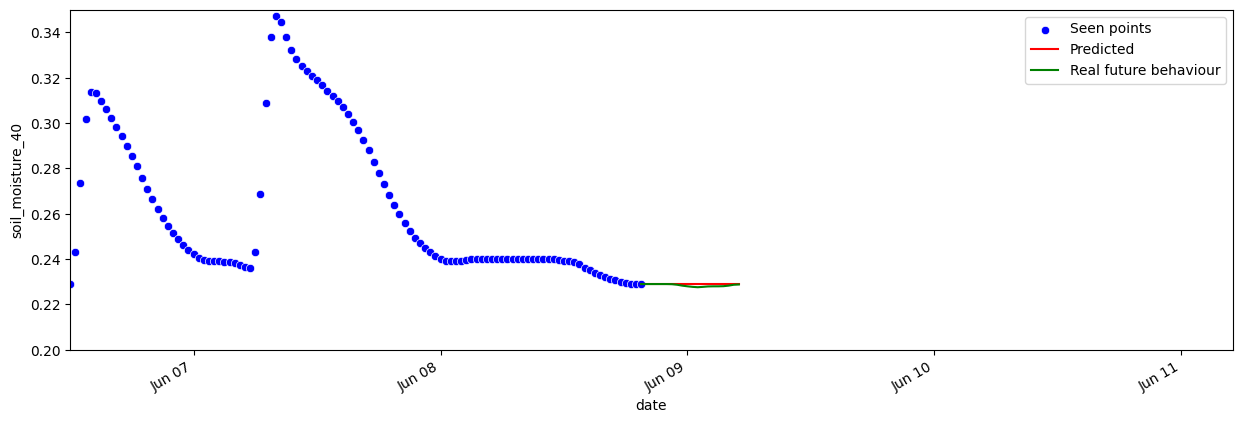

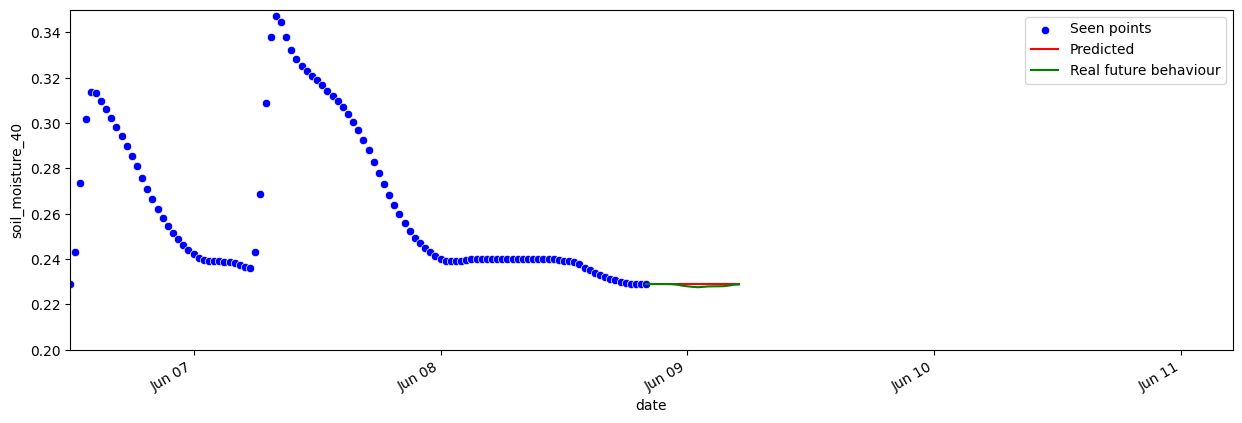

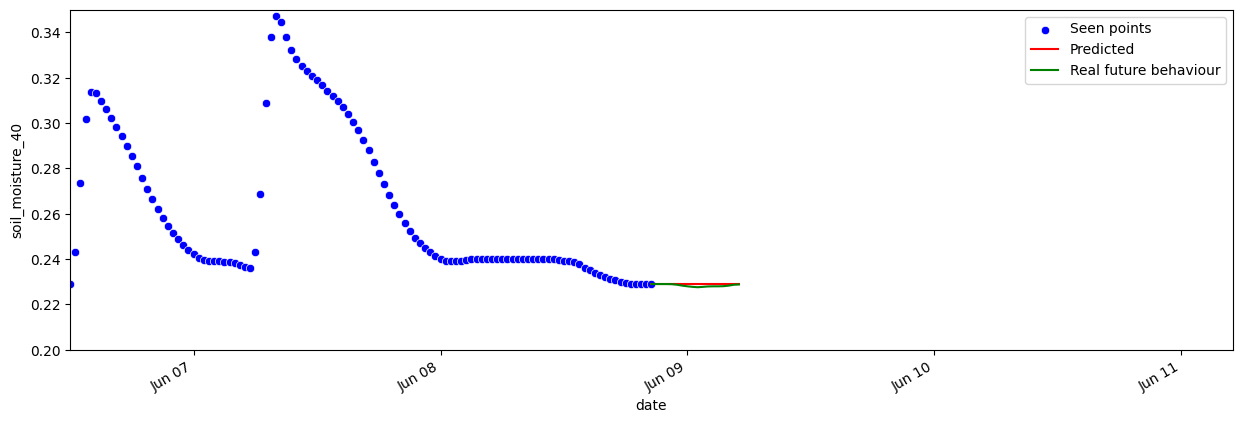

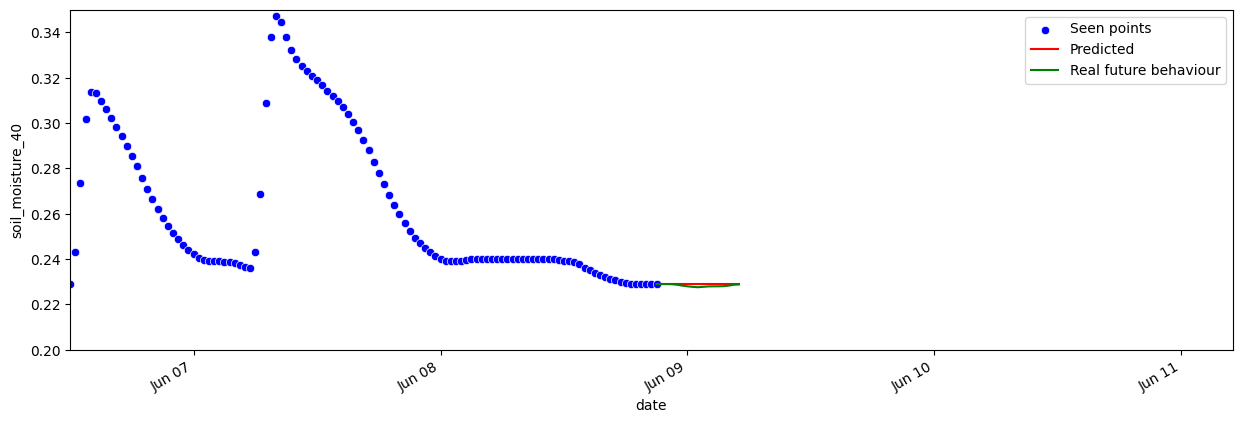

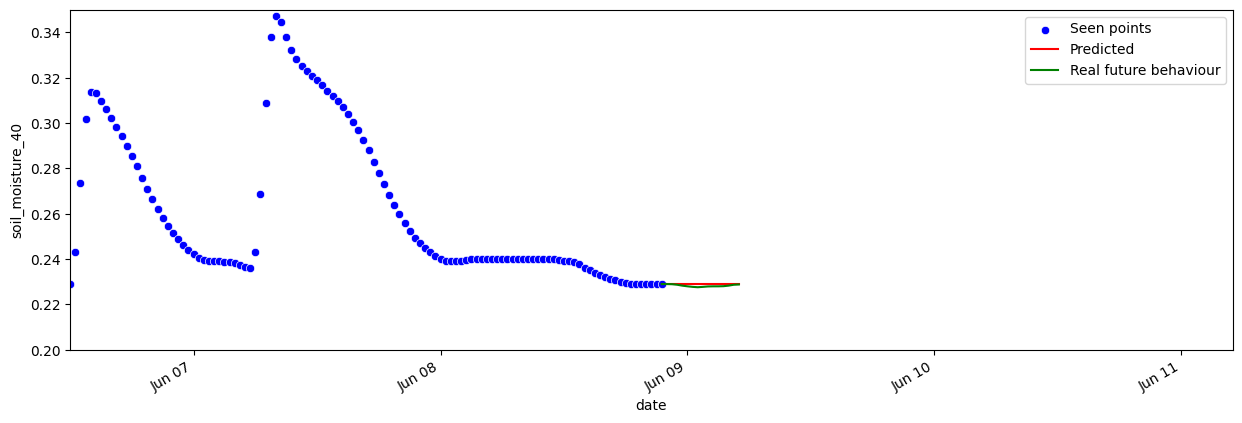

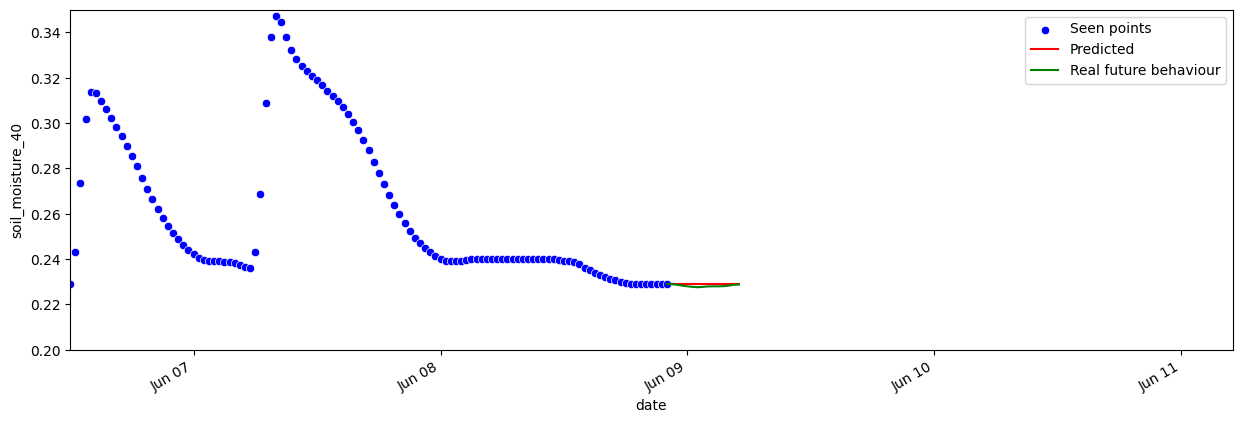

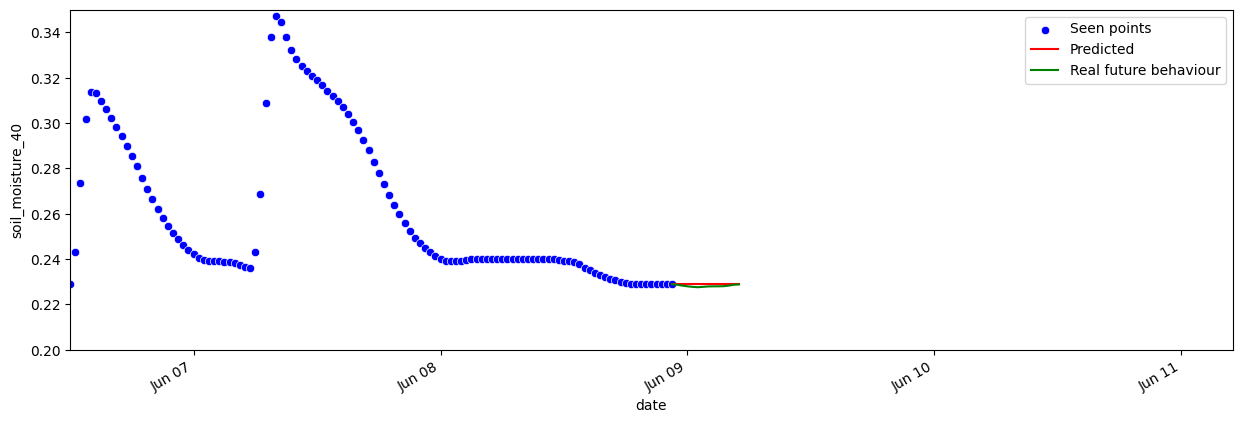

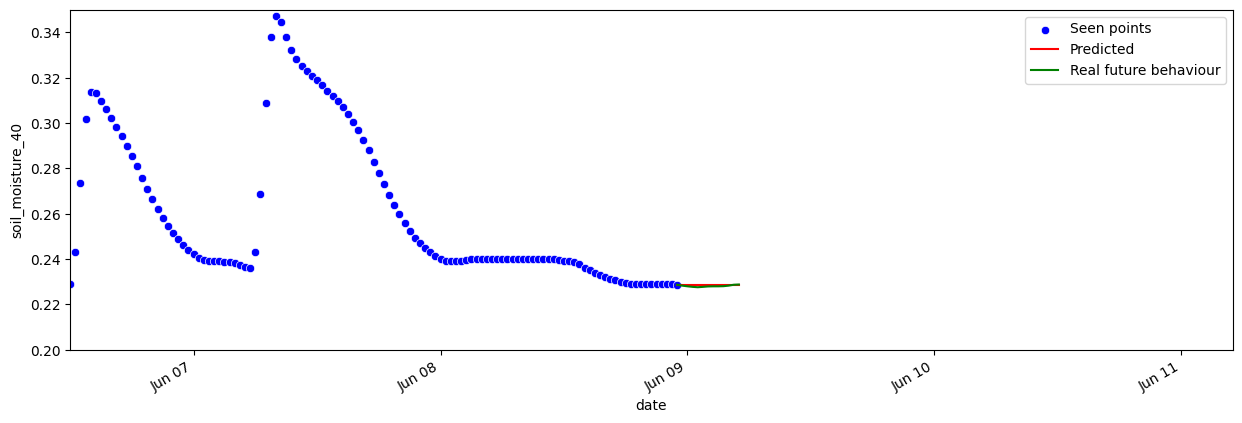

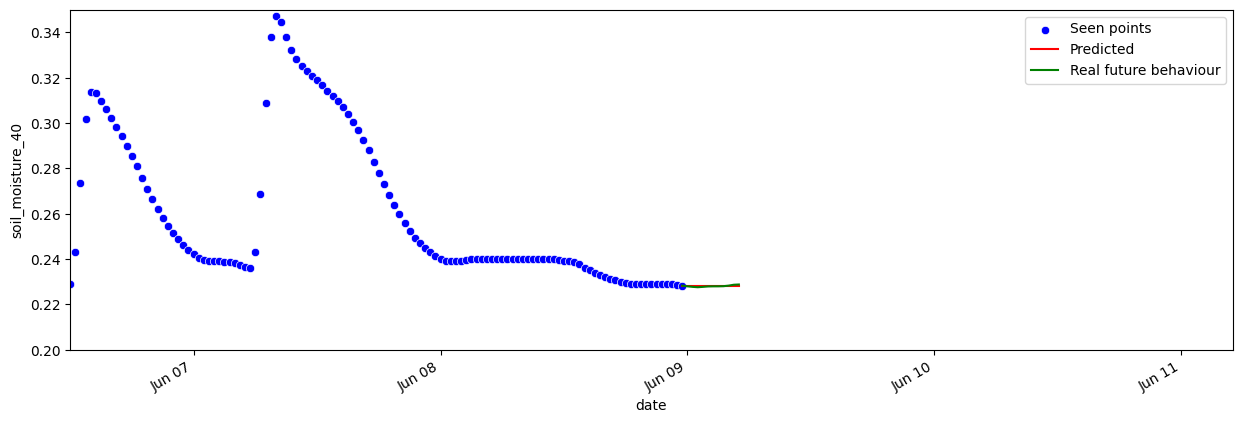

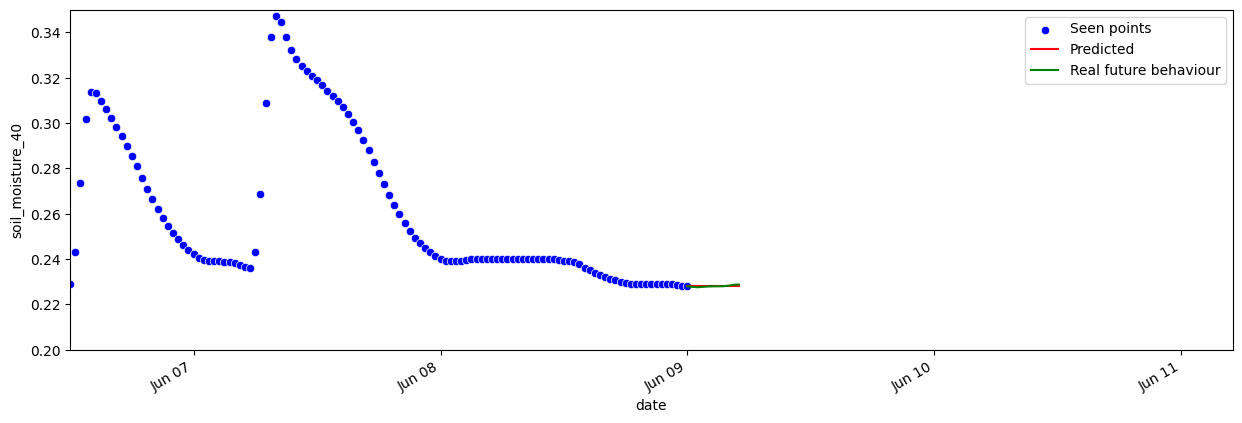

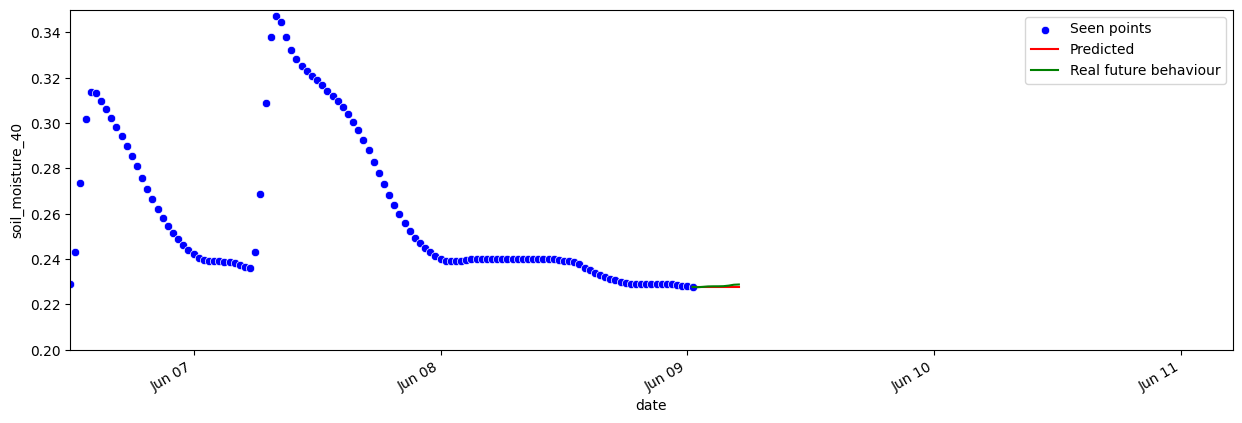

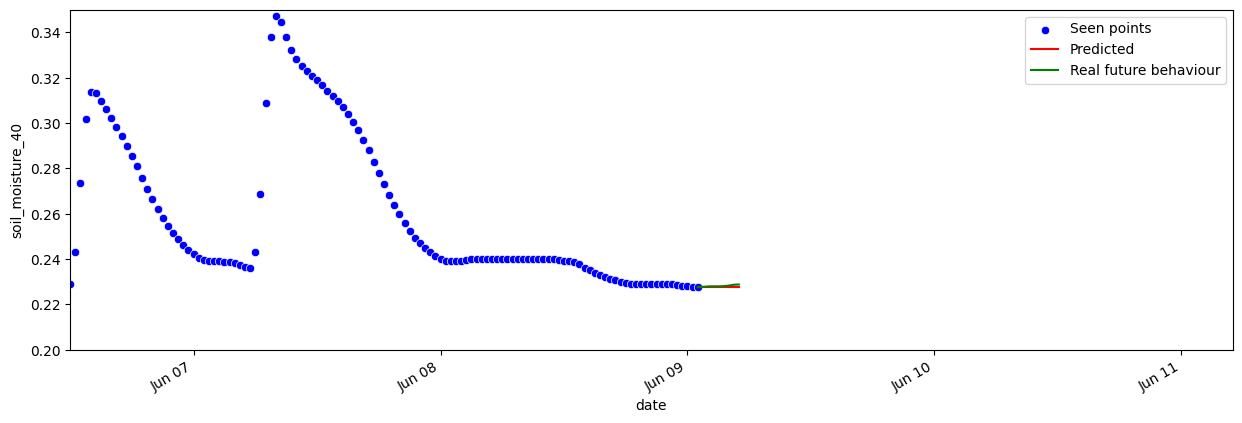

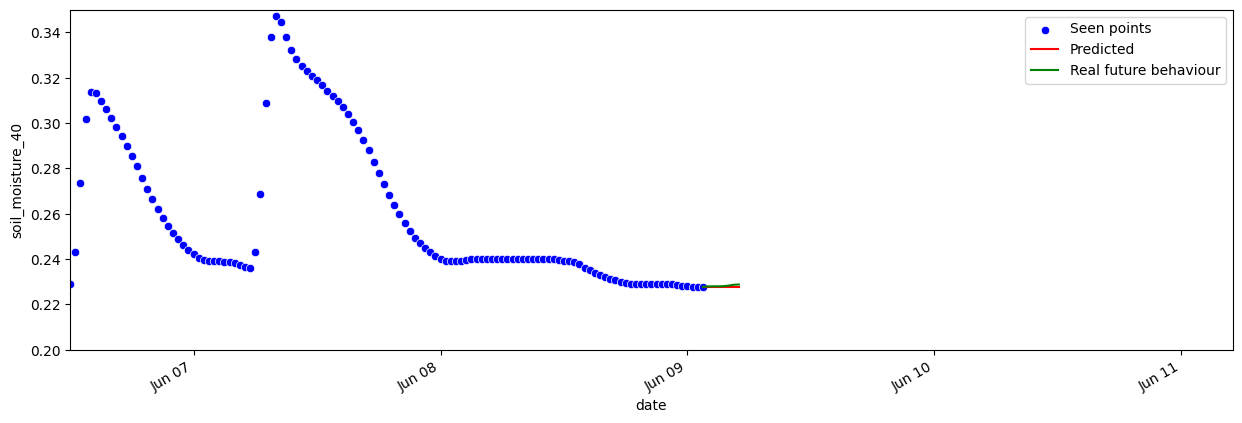

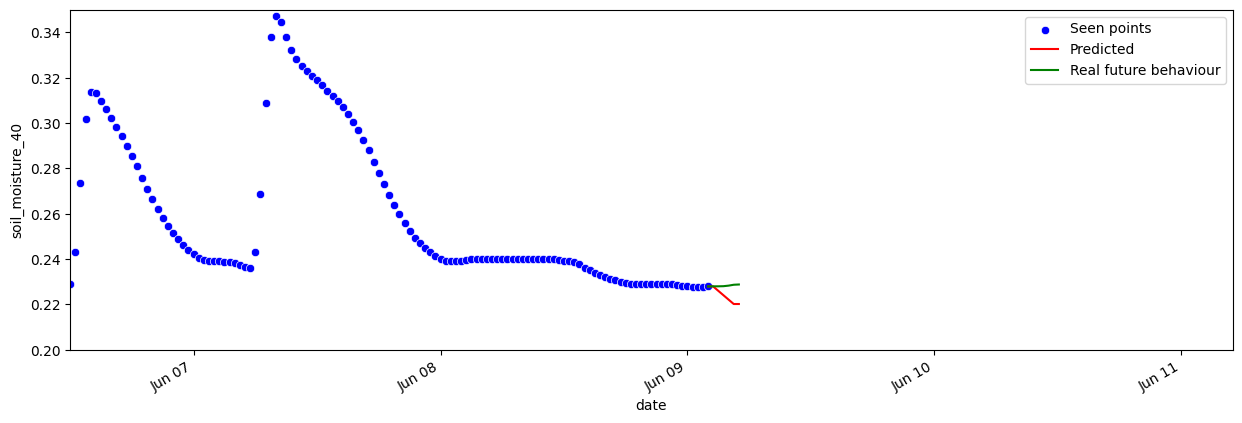

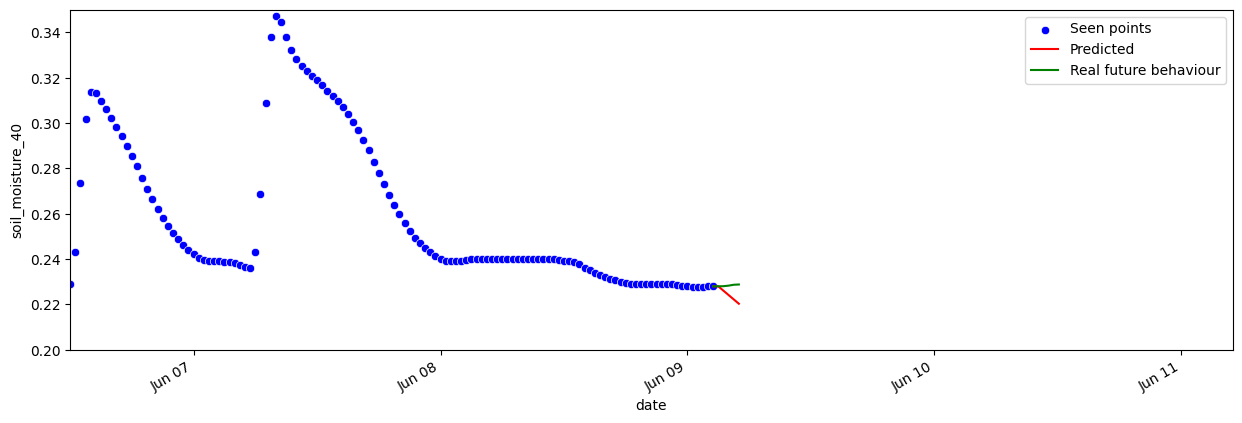

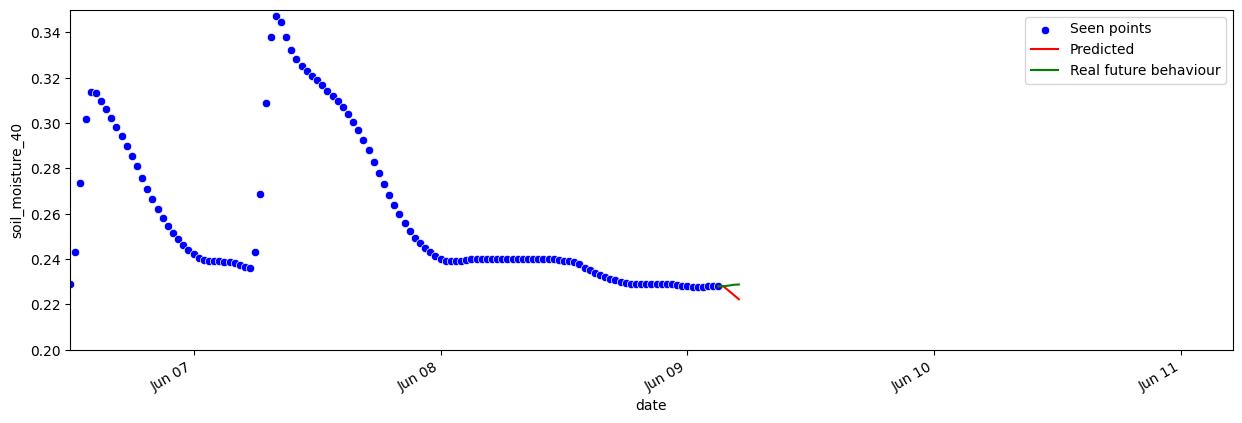

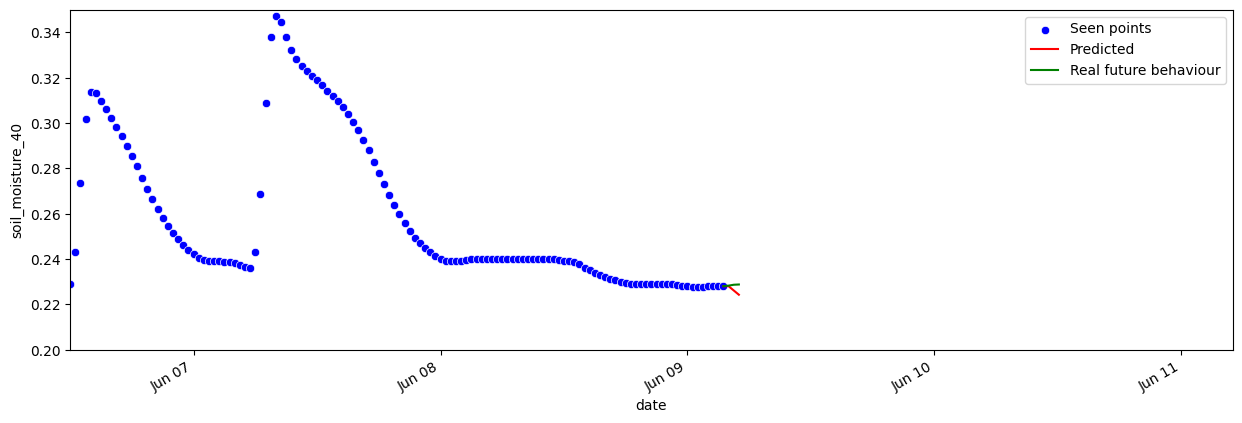

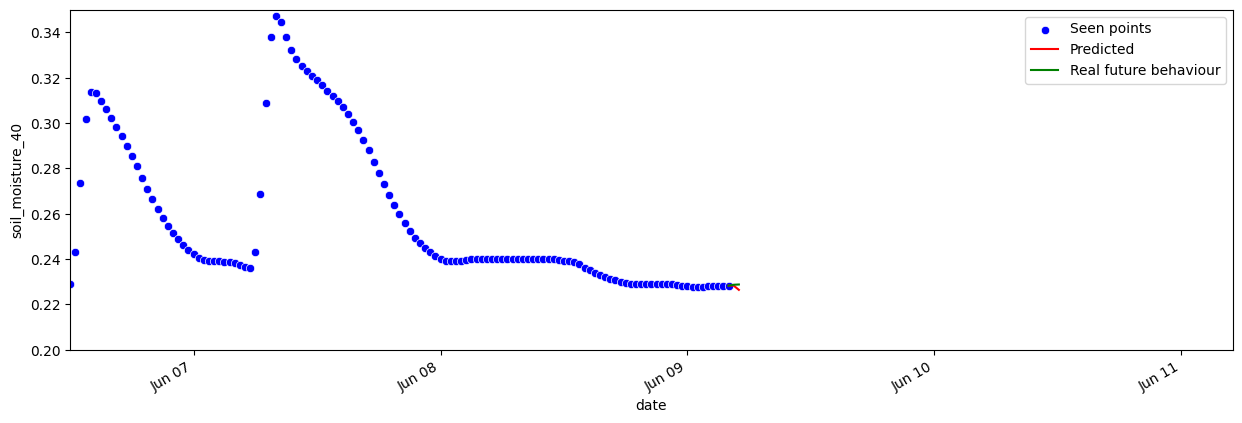

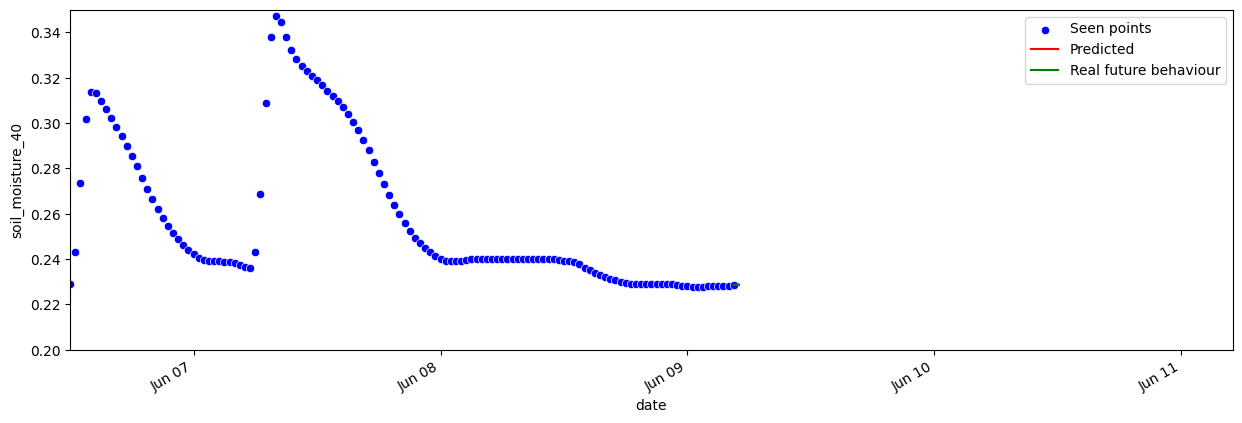

KeyError: 25292

In [ ]:
from tqdm.notebook import tqdm

start_date = pd.to_datetime("2024-06-06 12:00:00")
end_date   = pd.to_datetime("2024-06-11 05:00:00")
df_constricted = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

df_predicted = df.copy()

df_predicted["season"] = df_predicted["date"].dt.month.apply(get_season)

df_predicted = pd.get_dummies(df_predicted, columns=['season'])

df_predicted = df_predicted[(df_predicted["date"] >= start_date) & (df_predicted["date"] <= end_date)]
mask = df_predicted["irrigation_volume_0"] > 0
first_point = mask[mask].index[0]
df_predicted = df_predicted.loc[first_point:].copy()

print(len(df_predicted))

epoch = 0

beta = 0.3

irrigation = False
current_points = []
current_m = None
current_b = None
beginning_idx = df_predicted.index[0]
final_predicted = []
new_prediction = None
errors = pd.DataFrame()

#Simulates the passing of time and arrival of data to see the evolution of the forecastings
for idx in tqdm(df_predicted.index, desc="Processing rows:", unit="row"):

    #Huge increases means we are still not decaying
    if df_predicted.loc[idx, "irrigation_volume_0"] > 0 or df_predicted.loc[idx, "gradient_std"] > 0.4:
        current_m = None

        if new_prediction is not None:
            final_predicted.append(new_prediction.loc[beginning_idx:idx])

        new_prediction = None
        beginning_idx = idx
        current_points = []
        
        continue


    #If we are on a plain then we do not add the points to no mess with the linear regression.
    if not (df_predicted.loc[idx, "gradient_std"] > THRESH_DOWN) & (df_predicted.loc[idx, "gradient_std"] <= THRESH_DOWN):
        current_points.append(df_predicted.loc[idx, "soil_moisture_40"])

    
    #Update regression and plot the forecast.
    if len(current_points) > 3:
        m1 = line_regression(current_points)
        current_m = beta * m1 + (1-beta)*current_m
        current_b = current_points[-1]

    elif len(current_points) == 3:
        current_m = line_regression(current_points)
        current_b = current_points[0]

    if current_m != None:
        epoch += 1
        new_prediction = update_prediction(df_predicted, current_m, current_b, idx)

        # create_frame(new_prediction.loc[beginning_idx:], df_constricted,epoch,final_predicted)
        create_frame_pointed(df_predicted, new_prediction, epoch, idx)

            


[0.         0.00105338 0.0021651  0.00443572 0.00674152 0.0092683
 0.01196707 0.01469614 0.01744668 0.02020811 0.02298028 0.02577214
 0.02858507 0.03141416 0.03425561 0.03709884 0.03993909 0.04240519
 0.04438076 0.04583198 0.04704948 0.04817274 0.04913299 0.05001833
 0.05082844 0.0516402  0.05245209 0.05326398 0.05407587 0.0548879
 0.05563296 0.05638535 0.05708382 0.05778812 0.05841347 0.0590342
 0.0595881  0.06014769 0.06070878 0.06140449 0.06210034 0.06266858
 0.06317788 0.06357899 0.06392852 0.06427957 0.06462925 0.06497323
 0.06551854 0.0657054  0.06584459 0.06598528 0.06612597 0.06621748
 0.0663492  0.06646884 0.06653241 0.06650573 0.06648513 0.06649012
 0.06639744 0.06630639 0.06621548 0.06618346 0.06615146 0.06606068
 0.06597141 0.06588783 0.06580901 0.06584984 0.06582161 0.06573083
 0.06563993 0.06554902 0.06550207 0.06541116 0.06532025 0.06522935
 0.06513857 0.0650493  0.06496572 0.0648869  0.06480333 0.06471406
 0.0647197  0.06462893 0.06453979 0.06445799 0.06438828 0.0643259

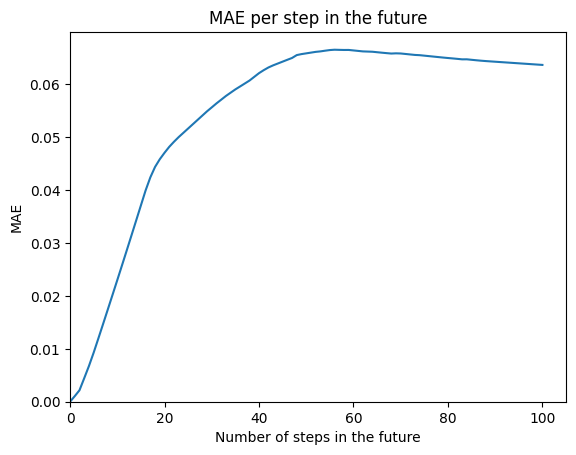

In [ ]:
mae_per_step = errors.mean().to_numpy()
plt.plot(mae_per_step)
plt.title("MAE per step in the future")
plt.ylabel("MAE")
plt.xlabel("Number of steps in the future")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [ ]:
# import imageio.v2 as imageio
# from pathlib import Path

# image_files = sorted(Path("frames_line").glob("*.png"))

# frames = [imageio.imread(img) for img in image_files]

# imageio.mimsave("animation_line.gif", frames, fps=1)